In [1]:
import osmnx as ox
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, Normalize
import networkx as nx
import pandana
import keplergl
import IPython
import base64
from shapely import Point
import geopandas as gpd
import warnings
import folium
import mapclassify
from scipy.stats import kendalltau, pearsonr, spearmanr, linregress, stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, kstest, norm

In [2]:
# Notebook themes
#!jt -l

In [3]:
# Notebook themes
#!jt -t chesterish
#!jt -t onedork -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115 -altmd  -kl -T -N
#!jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T

#### Importing the network

In [4]:
place = 'Napoli, Italia'
G = ox.graph_from_place(place, network_type='walk', simplify = True)

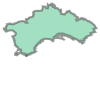

In [5]:
# Download the boundary of the city
city_polygon = ox.geocode_to_gdf(place)['geometry'].iloc[0]
city_polygon

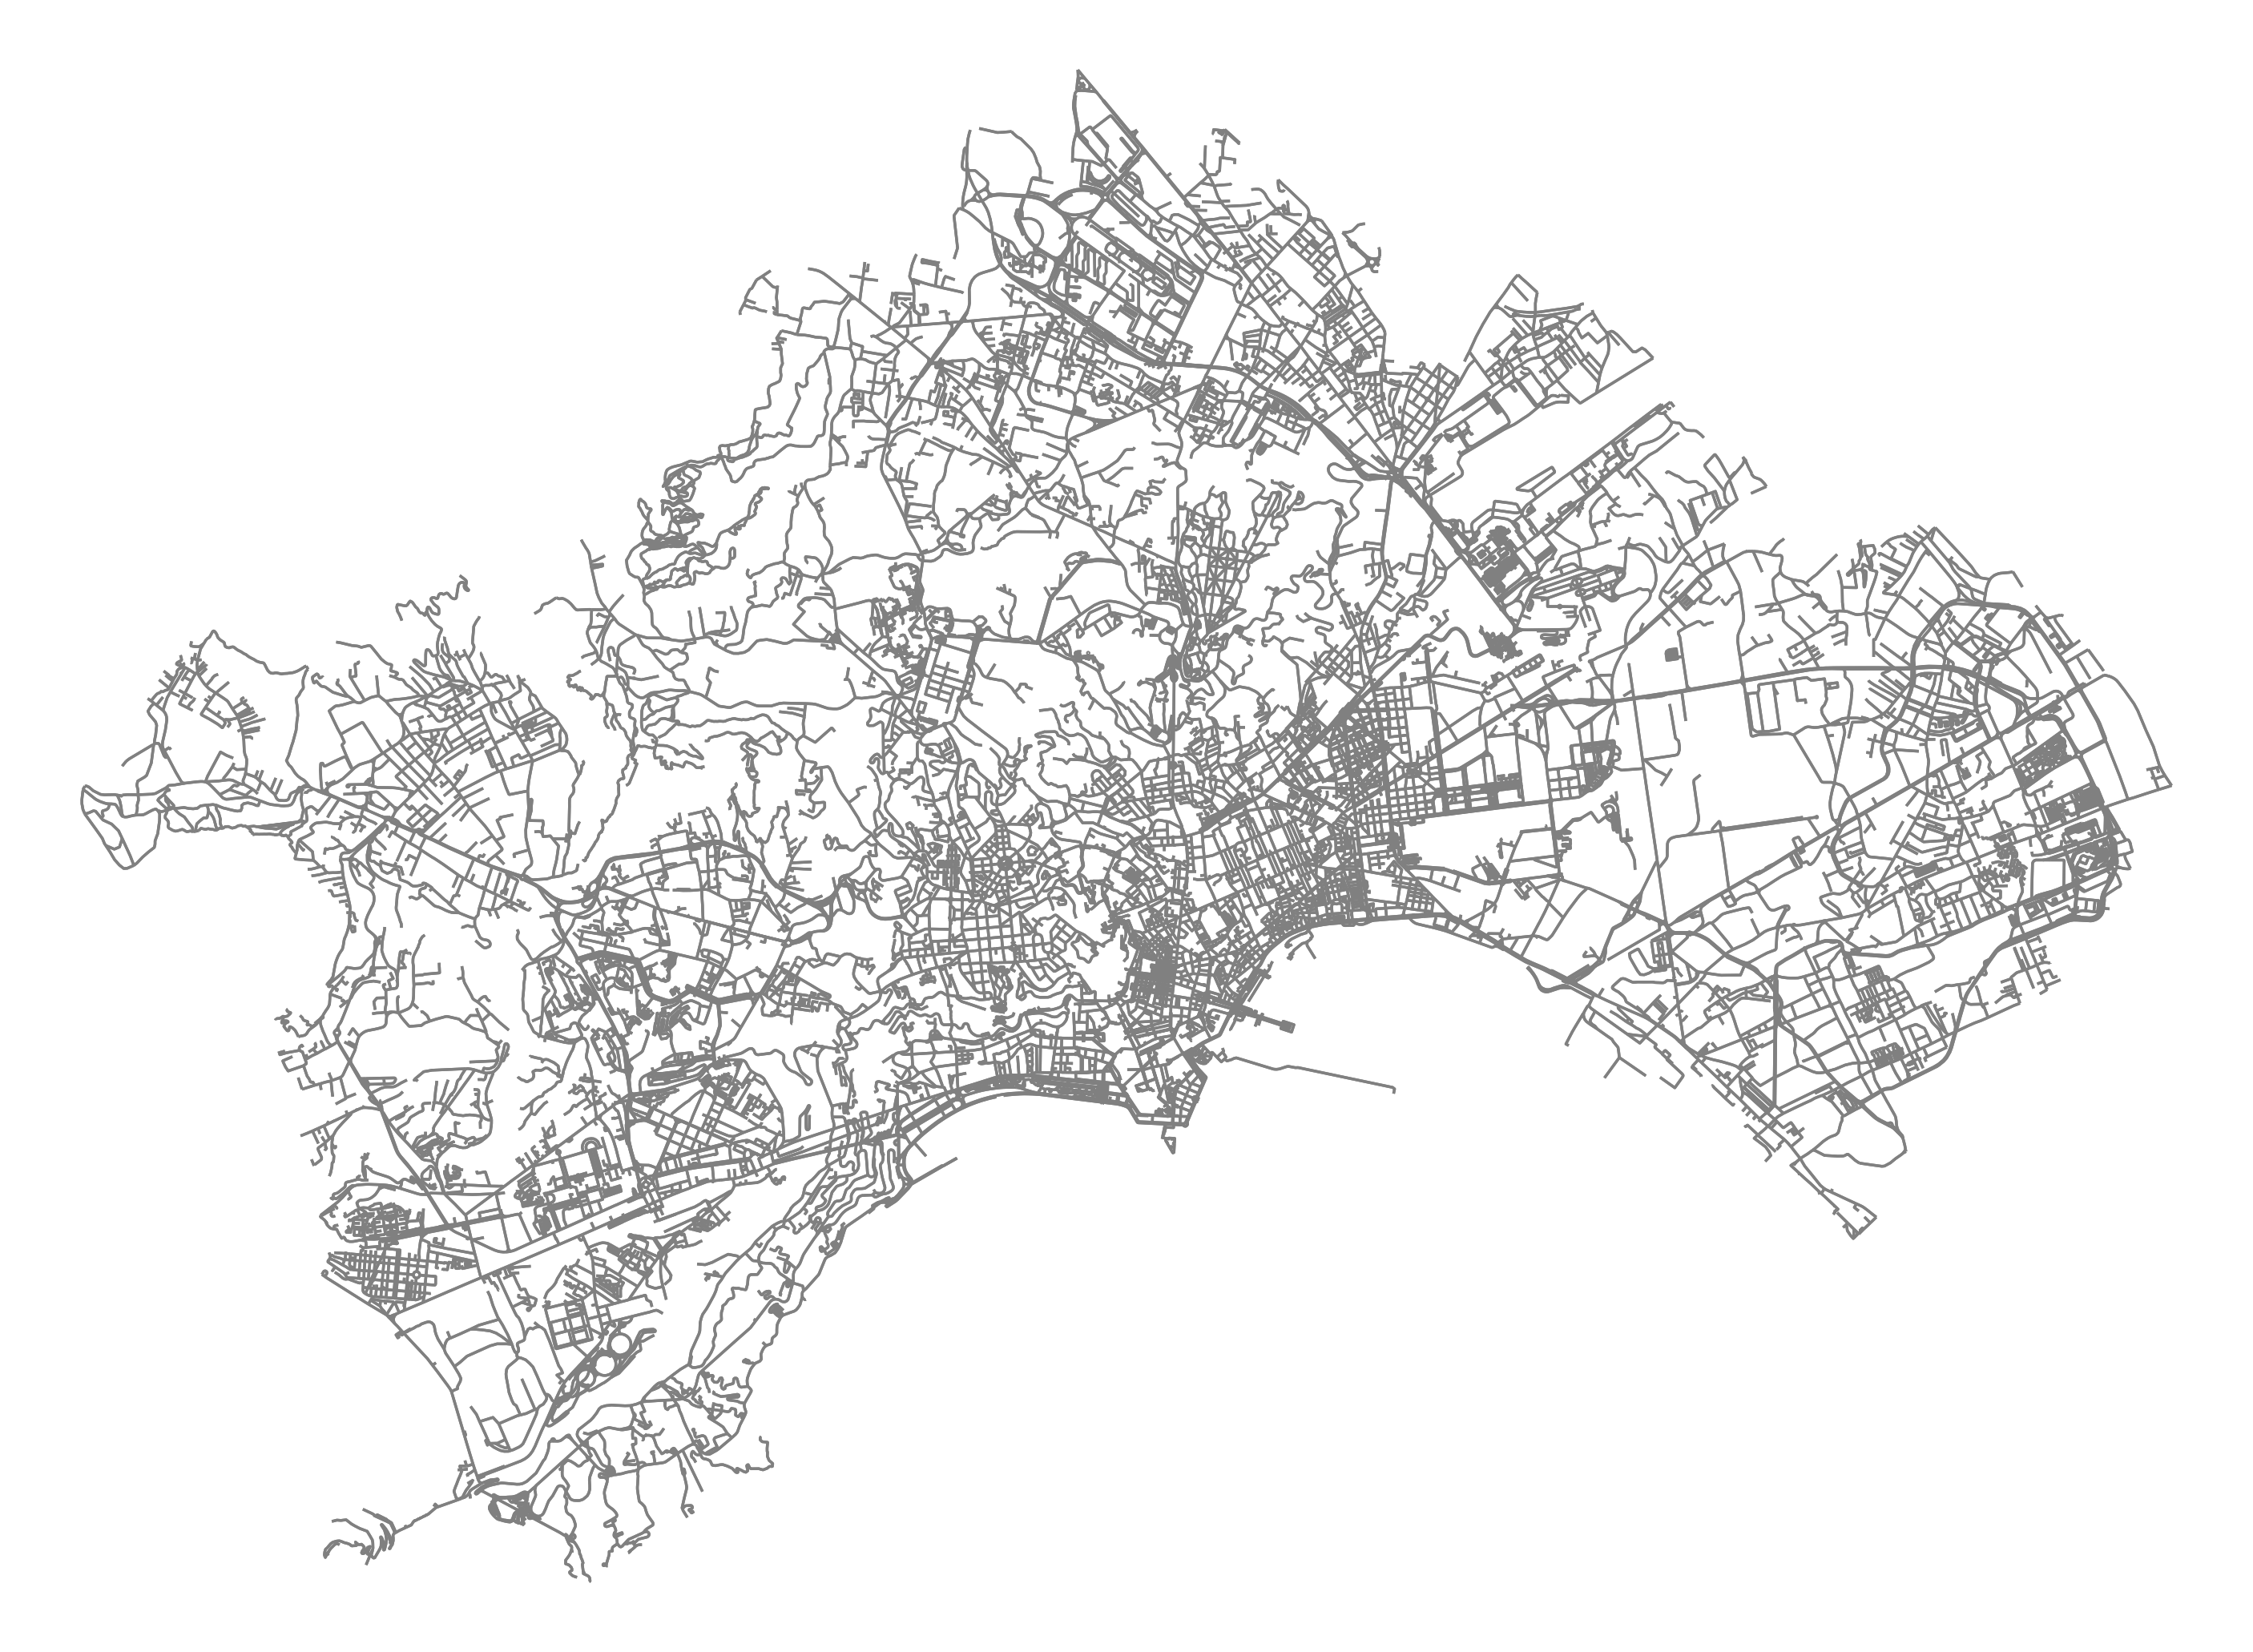

In [6]:
mpl.rcParams['figure.dpi'] = 500
#fig, ax = ox.plot_graph(ox.project_graph(G), node_color='#4CFFD6', node_size=0.5,
#                       edge_color='#4CFFD6', edge_linewidth=0.1, 
#                       figsize=(7, 7))

fig, ax = ox.plot_graph(ox.project_graph(G), 
                       figsize=(7, 7), node_size = 0, bgcolor="white", node_color = "black", 
                       edge_color='gray', edge_linewidth=0.5)


In [7]:
nodes, edges = ox.graph_to_gdfs(G, nodes = True, edges= True)

In [8]:
nodes.head(3)

y          x  street_count highway  \
osmid                                                  
15588479  40.844128  14.184561             3     NaN   
15588483  40.847009  14.183698             3     NaN   
15588486  40.847125  14.183636             3     NaN   

                           geometry  
osmid                                
15588479  POINT (14.18456 40.84413)  
15588483  POINT (14.18370 40.84701)  
15588486  POINT (14.18364 40.84713)

In [9]:
edges.head(3)

osmid  oneway         highway reversed   length  \
u        v          key                                                       
15588479 15588578   0     3211846   False  secondary_link    False   17.538   
         2633707866 0    22789953   False       secondary    False   28.833   
         3383248580 0    22789953   False       secondary     True  106.575   

                                                                  geometry  \
u        v          key                                                      
15588479 15588578   0    LINESTRING (14.18456 40.84413, 14.18451 40.844...   
         2633707866 0    LINESTRING (14.18456 40.84413, 14.18448 40.844...   
         3383248580 0    LINESTRING (14.18456 40.84413, 14.18477 40.843...   

                                             name bridge junction lanes  ref  \
u        v          key                                                        
15588479 15588578   0                         NaN    NaN      NaN   NaN  NaN   
         2633707866 0    Via Vicinale Cupa Cintia    NaN      NaN   NaN  NaN   
         3383248580 0    Via Vicinale Cupa Cintia    NaN      NaN   NaN  NaN   

                        tunnel maxspeed width access est_width service area  
u        v          key                                                      
15588479 15588578   0      NaN      NaN   NaN    NaN       NaN     NaN  NaN  
         2633707866 0      NaN      NaN   NaN    NaN       NaN     NaN  NaN  
         3383248580 0      NaN      NaN   NaN    NaN       NaN     NaN  NaN

##### Creating Pandana Graph for shortest path calculation

In [10]:
# FOR PANDANA
edges_pdna = edges.droplevel(level=2)
edges_pdna["from"] = edges_pdna.index.get_level_values("u")
edges_pdna["to"] = edges_pdna.index.get_level_values("v")
edges_pdna = edges_pdna.drop(['osmid', 'highway', "oneway", "reversed",
                "lanes", "name", "geometry", "maxspeed",
                "access", "junction", "width", "bridge",
                "tunnel", "service", "ref", "est_width", 
                "area"], axis=1)
edges_pdna.insert(2, "length", edges_pdna.pop("length"))
edges_pdna

from           to   length
u           v                                             
15588479    15588578        15588479     15588578   17.538
            2633707866      15588479   2633707866   28.833
            3383248580      15588479   3383248580  106.575
15588483    15588486        15588483     15588486   14.271
            244924333       15588483    244924333   95.079
...                              ...          ...      ...
11989908172 11989880768  11989908172  11989880768  125.604
11989958308 2191392298   11989958308   2191392298   23.503
            11989958309  11989958308  11989958309  102.743
            2191392320   11989958308   2191392320   92.708
11989958309 11989958308  11989958309  11989958308  102.743

[58218 rows x 3 columns]

In [11]:
nodes_pdna = nodes[["x", "y"]]

In [12]:
G_pdna = pandana.Network(nodes_pdna['x'], nodes_pdna['y'], 
                          edges_pdna['from'], edges_pdna['to'], 
                          edges_pdna[['length']], twoway = True)

#### Defining X minutes city

In [13]:
X_minutes = 15

#### Defining hotels (source nodes)

In [14]:
# Importing the complete hotel dataset
hotel_col_names = ["gcode_H", "dcode_H", "name_H", "score_H", "review_count_H", 
                  "x_H", "y_H", "istat_pro_com_H", "municipality_H", "hotel_class", 
                  "type_H", "price_5_6_august", "price_range_min", "price_range_max", 
                  "avg_price", "n_rooms", "location_score"] 
hotels_total = pd.read_excel("hotel_dataset_Napoli.xlsx", sheet_name = "hotel_dataset_cleaned_filtered", 
                            names = hotel_col_names)

hotels_total["hotel_class"] = pd.to_numeric(hotels_total["hotel_class"], errors='coerce')

print("Total number of accomodations for all cities in dataset: ", len(hotels_total))
hotels_total.head(3)

Total number of accomodations for all cities in dataset:  509


gcode_H    dcode_H                        name_H  score_H  review_count_H  \
0  g187785   d6895209                    Domus Rosa      5.0             206   
1  g187785    d267010  Hotel San Francesco al Monte      4.0            1268   
2  g187785  d12405574                B&B Maryflower      4.0              18   

         x_H        y_H  istat_pro_com_H municipality_H  hotel_class  \
0  14.257269  40.849225            63049         Napoli          NaN   
1  14.243914  40.844309            63049         Napoli          4.0   
2  14.266621  40.853152            63049         Napoli          NaN   

      type_H  price_5_6_august  price_range_min  price_range_max  avg_price  \
0  Non-Hotel               NaN            114.0            137.0      125.5   
1      Hotel             275.0            259.0            330.0      294.5   
2  Non-Hotel               NaN            104.0            153.0      128.5   

   n_rooms  location_score  
0      3.0             4.9  
1     45.0             4.4  
2      NaN             4.5

In [15]:
# Filtering hotels by municipality, type, and presence inside bbox
hotels_df = hotels_total.copy()
print("Total number of accomodation in city: ", len(hotels_df.loc[hotels_df.municipality_H == "Napoli"]))

hotels_df['in_bbox'] = hotels_df.apply(lambda x: city_polygon.contains(Point(x.x_H, x.y_H)), axis=1)

hotels_df = hotels_df.loc[(hotels_df.municipality_H == "Napoli") & 
                          (hotels_df.type_H == "Hotel") & 
                         (hotels_df.in_bbox == True)].reset_index(drop=True)
hotels_df.drop("in_bbox", axis=1, inplace=True)
print("Number of hotels: ", len(hotels_df))
hotels_df.head(3)

Total number of accomodation in city:  509
Number of hotels:  243


gcode_H   dcode_H                        name_H  score_H  review_count_H  \
0  g187785   d267010  Hotel San Francesco al Monte      4.0            1268   
1  g187785  d6507804                  Napoli Suite      4.0             487   
2  g187785   d275674             Hotel Il Convento      4.5            1419   

         x_H        y_H  istat_pro_com_H municipality_H  hotel_class type_H  \
0  14.243914  40.844309            63049         Napoli          4.0  Hotel   
1  14.258518  40.845644            63049         Napoli          3.0  Hotel   
2  14.247444  40.838826            63049         Napoli          3.0  Hotel   

   price_5_6_august  price_range_min  price_range_max  avg_price  n_rooms  \
0             275.0            259.0            330.0      294.5     45.0   
1             105.0             96.0            131.0      113.5      7.0   
2             278.0            151.0            256.0      203.5     14.0   

   location_score  
0             4.4  
1             4.4  
2             4.7

In [16]:
# Getting the nearest node ids to each hotel

id_nearest_node_H, dist_H = ox.distance.nearest_nodes(G, hotels_df['x_H'], 
                                              hotels_df['y_H'], 
                                              return_dist=True)

print("Successful mapping: ", len(hotels_df) == len(id_nearest_node_H))


hotels_df.insert(7, "id_nearest_node_H", id_nearest_node_H)
hotels_df.insert(8, "x_nearest_node_H", 
                 np.float64(nodes.x[id_nearest_node_H]))
hotels_df.insert(9, "y_nearest_node_H", 
                 np.float64(nodes.y[id_nearest_node_H]))

hotels_df.head(3)

Successful mapping:  True


gcode_H   dcode_H                        name_H  score_H  review_count_H  \
0  g187785   d267010  Hotel San Francesco al Monte      4.0            1268   
1  g187785  d6507804                  Napoli Suite      4.0             487   
2  g187785   d275674             Hotel Il Convento      4.5            1419   

         x_H        y_H  id_nearest_node_H  x_nearest_node_H  \
0  14.243914  40.844309         3967102248         14.243979   
1  14.258518  40.845644          395034062         14.258505   
2  14.247444  40.838826         3837365539         14.247472   

   y_nearest_node_H  istat_pro_com_H municipality_H  hotel_class type_H  \
0         40.844233            63049         Napoli          4.0  Hotel   
1         40.845661            63049         Napoli          3.0  Hotel   
2         40.838989            63049         Napoli          3.0  Hotel   

   price_5_6_august  price_range_min  price_range_max  avg_price  n_rooms  \
0             275.0            259.0            330.0      294.5     45.0   
1             105.0             96.0            131.0      113.5      7.0   
2             278.0            151.0            256.0      203.5     14.0   

   location_score  
0             4.4  
1             4.4  
2             4.7

(Mean, Std):  15.8 15.2


<Axes: >

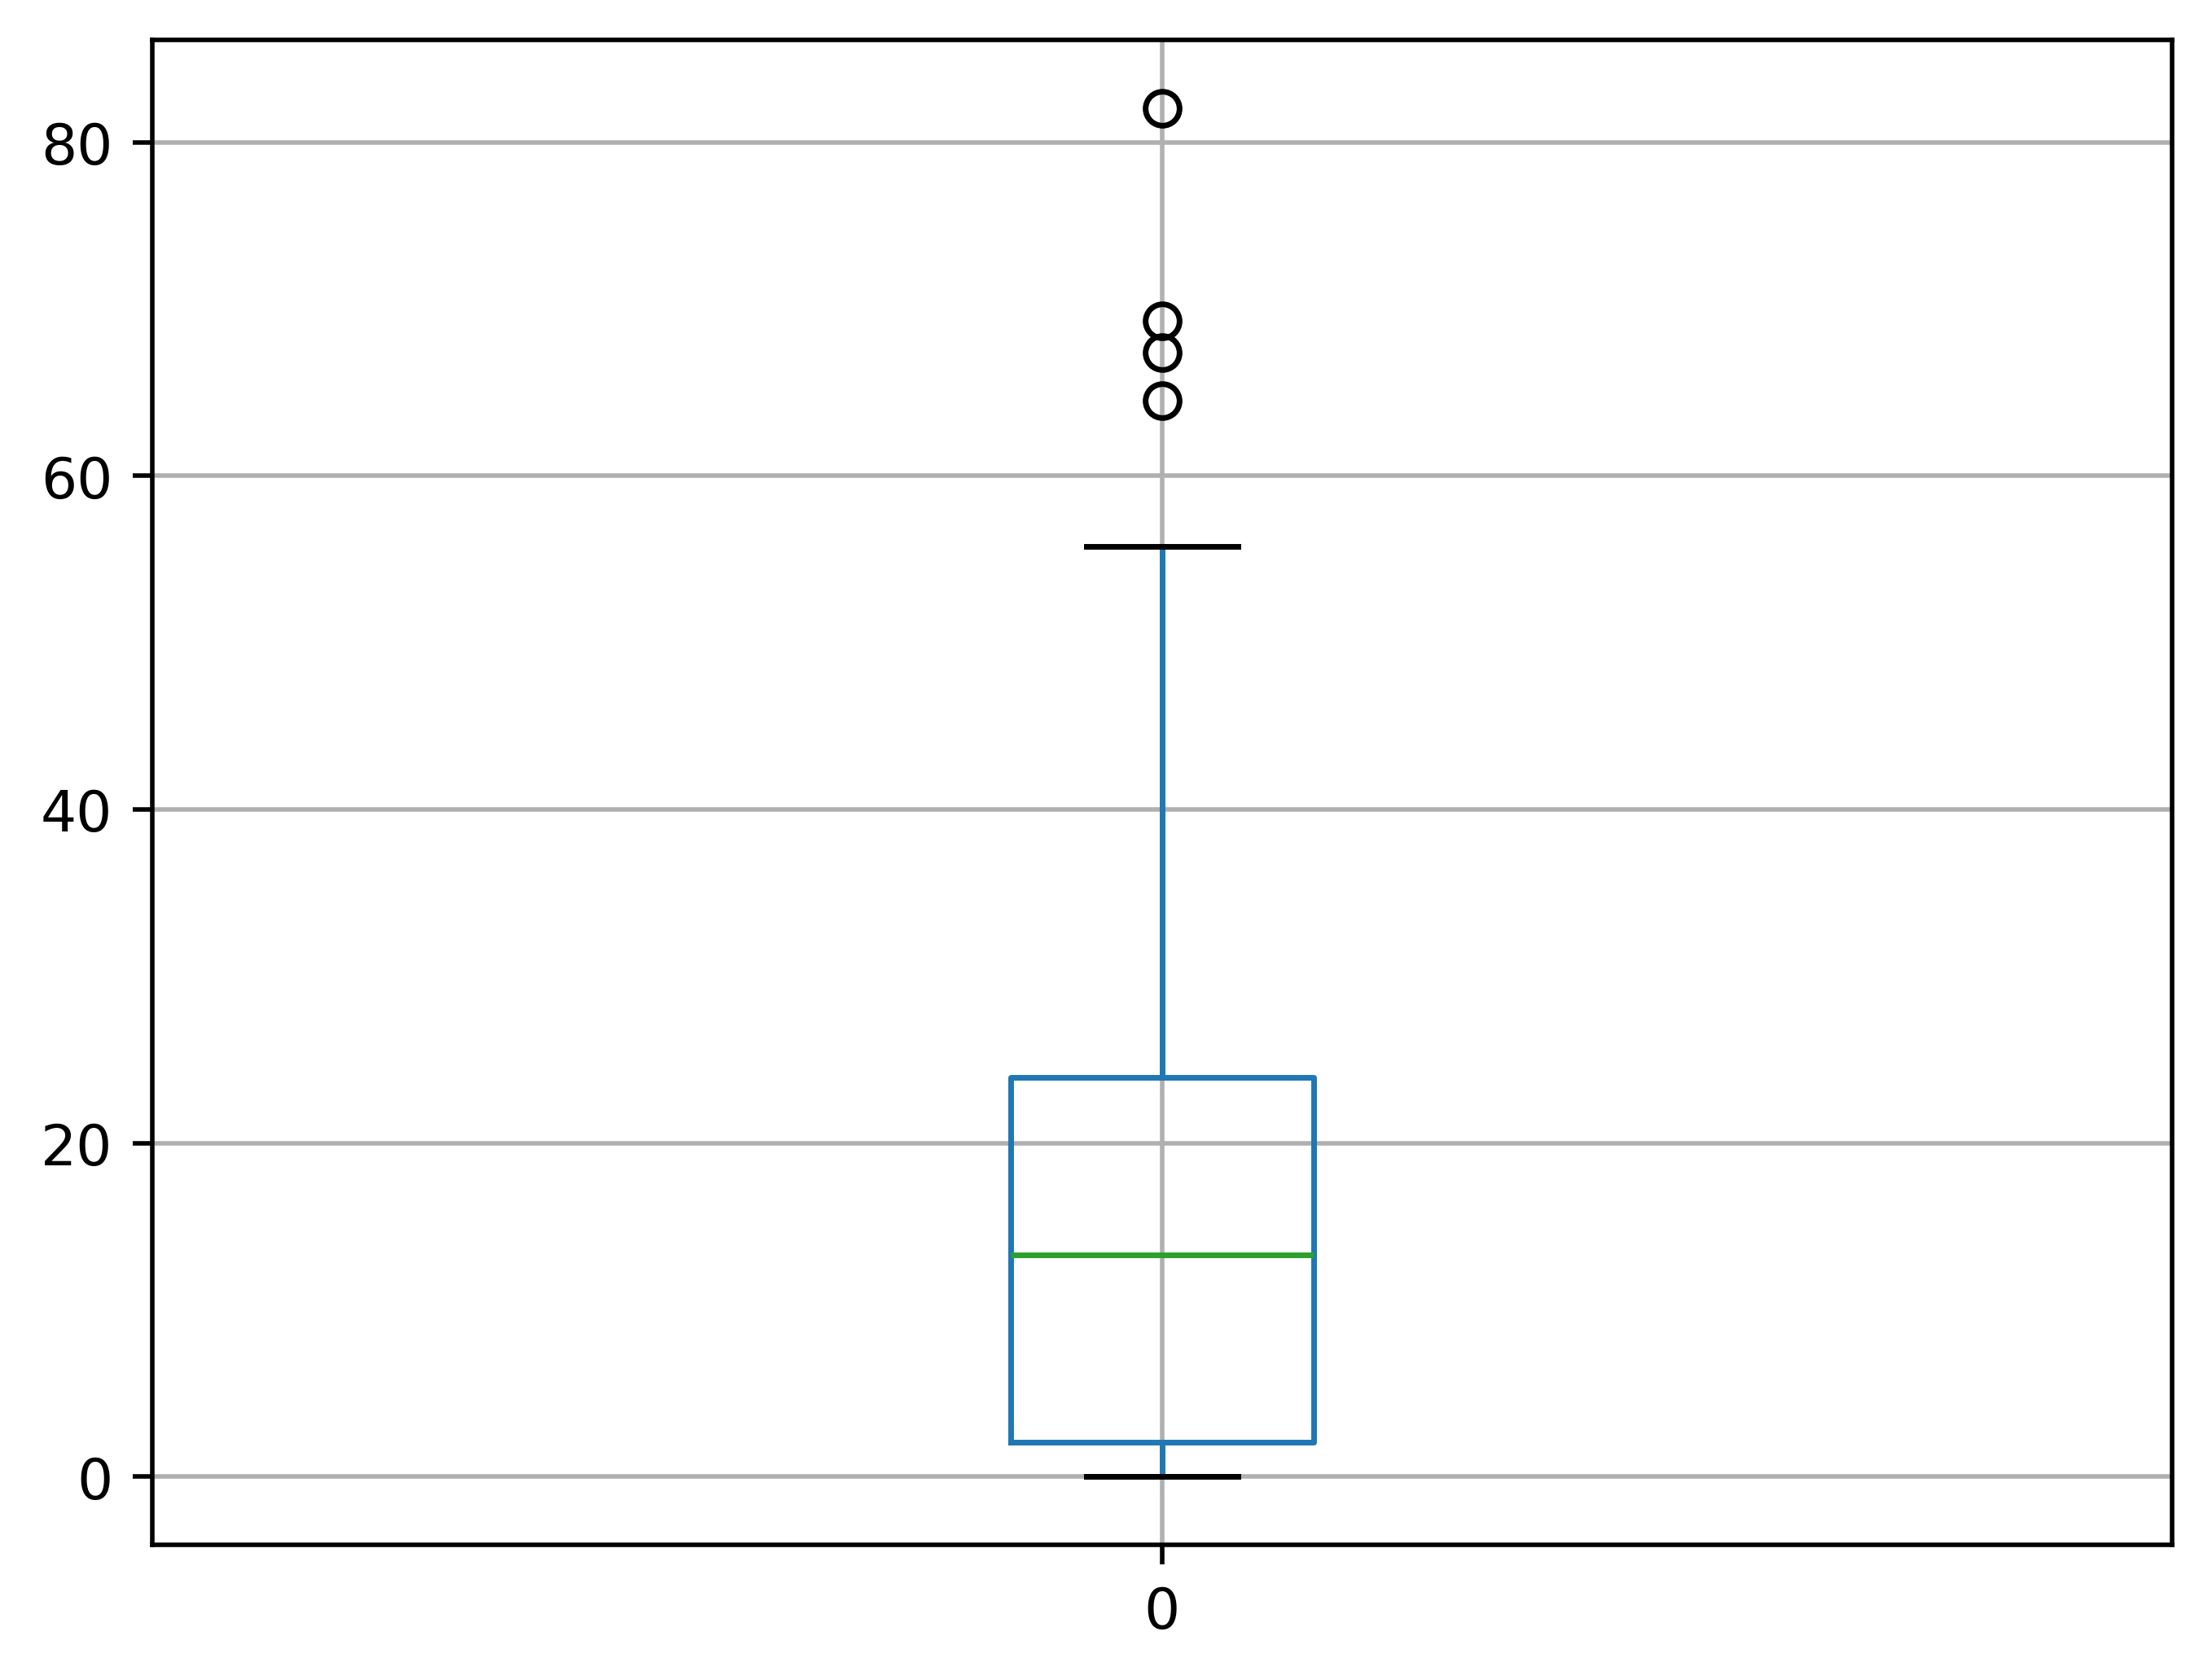

In [17]:
# Distribution of distance
print("(Mean, Std): ", np.around(np.mean(dist_H), decimals=1), np.around(np.std(dist_H), decimals=1))
pd.DataFrame(dist_H).boxplot()

Text(0, 0.5, 'review score')

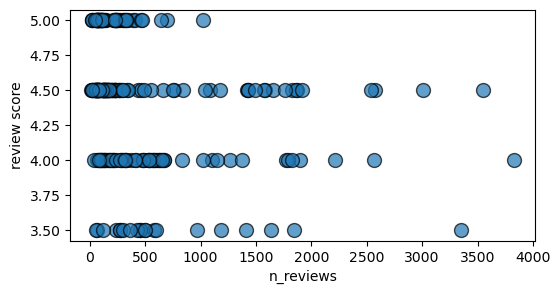

In [32]:
# Distribution of reviews as a function of number of reviews
# for the hotels
mpl.rcParams['figure.dpi'] = 100
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(hotels_df["review_count_H"], hotels_df["score_H"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [33]:
# Calculating Bayesian Average
#m = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
#C = 250
#hotels_df["Bayesian_avg_H"] = ((hotels_df.score_H * hotels_df.review_count_H) 
#                                  + (C * m)) / (C + hotels_df.review_count_H)

S = np.mean(hotels_df.score_H[hotels_df["score_H"] > 0])
m_avg = np.mean(hotels_df.review_count_H[hotels_df["score_H"] > 0])

hotels_df["Bayesian_avg_H"] = (hotels_df.review_count_H/(hotels_df.review_count_H + m_avg)) * hotels_df.score_H +\
                                (m_avg/(hotels_df.review_count_H + m_avg)) * S
hotels_df = hotels_df[(hotels_df.score_H > 0) & (hotels_df.review_count_H > 0)]
print("Number of accommodations: ", len(hotels_df))
hotels_df.head(3)

Number of accommodations:  243


gcode_H   dcode_H                        name_H  score_H  review_count_H  \
0  g187785   d267010  Hotel San Francesco al Monte      4.0            1268   
1  g187785  d6507804                  Napoli Suite      4.0             487   
2  g187785   d275674             Hotel Il Convento      4.5            1419   

         x_H        y_H  id_nearest_node_H  x_nearest_node_H  \
0  14.243914  40.844309         3967102248         14.243979   
1  14.258518  40.845644          395034062         14.258505   
2  14.247444  40.838826         3837365539         14.247472   

   y_nearest_node_H  ...  municipality_H hotel_class  type_H price_5_6_august  \
0         40.844233  ...          Napoli         4.0   Hotel            275.0   
1         40.845661  ...          Napoli         3.0   Hotel            105.0   
2         40.838989  ...          Napoli         3.0   Hotel            278.0   

   price_range_min  price_range_max  avg_price  n_rooms  location_score  \
0            259.0            330.0      294.5     45.0             4.4   
1             96.0            131.0      113.5      7.0             4.4   
2            151.0            256.0      203.5     14.0             4.7   

   Bayesian_avg_H  
0        4.109774  
1        4.198656  
2        4.475130  

[3 rows x 21 columns]

<Axes: xlabel='Hotel class', ylabel='Count'>

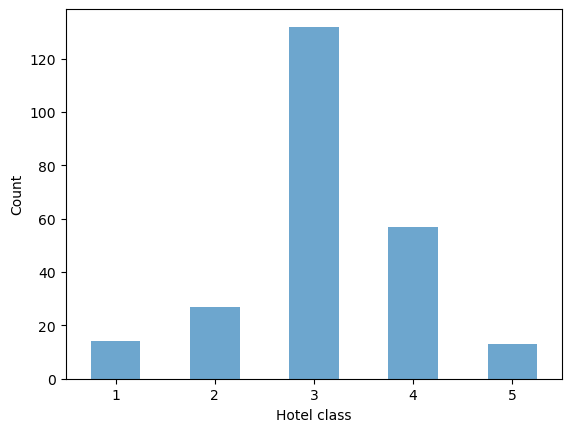

In [34]:
pd.DataFrame(hotels_df.hotel_class.sort_values().astype(int).value_counts(sort=False)).plot.bar(alpha=0.65, xlabel="Hotel class", ylabel="Count", rot=0, legend=False)

#### Defining attractions (destination nodes)

In [35]:
# Importing the complete attractions dataset
attractions_col_names = ["gcode_A", "dcode_A", "name_A", "score_A", "review_count_A", 
                         "x_A", "y_A", "istat_pro_com_A", "municipality_A"] 

attractions_total = pd.read_excel("attraction_dataset.xlsx", sheet_name = "attraction_dataset", 
                                  names = attractions_col_names)

attractions_total.head(3)

gcode_A   dcode_A                    name_A  score_A  review_count_A  \
0  g187785  d2161503        Galleria Borbonica      5.0           10365   
1  g187867   d269082  Cappella degli Scrovegni      5.0            7170   
2  g187867  d8660480               Villa Molin      5.0              35   

         x_A        y_A  istat_pro_com_A municipality_A  
0  14.246260  40.835520            63049         Napoli  
1  11.879536  45.411818            28060         Padova  
2  11.840058  45.362549            28060         Padova

In [36]:
# Filtering attractions by municipality and presence inside bbox
attractions_df = attractions_total.copy()
attractions_df['in_bbox'] = attractions_df.apply(lambda x: city_polygon.contains(Point(x.x_A, x.y_A)), axis=1)
attractions_df = attractions_df.loc[(attractions_df.municipality_A == "Napoli") &
                                   (attractions_df.in_bbox == True)].reset_index(drop=True)
attractions_df.drop("in_bbox", axis=1, inplace=True)
print("Number of attractions: ", len(attractions_df))
attractions_df.head(3)

Number of attractions:  790


gcode_A   dcode_A                     name_A  score_A  review_count_A  \
0  g187785  d2161503         Galleria Borbonica      5.0           10365   
1  g187785   d243315   Catacombe di San Gennaro      5.0            5680   
2  g187785  d4063391  Catacombe di San Gaudioso      5.0            1659   

         x_A        y_A  istat_pro_com_A municipality_A  
0  14.246260  40.835520            63049         Napoli  
1  14.247445  40.865059            63049         Napoli  
2  14.249435  40.859502            63049         Napoli

Text(0, 0.5, 'review score')

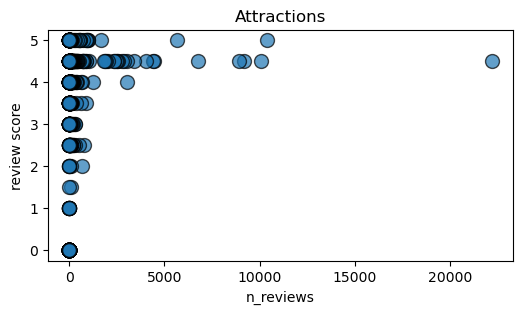

In [37]:
# Distribution of reviews as a function of number of reviews
# for the attractions
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(attractions_df["review_count_A"], attractions_df["score_A"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Attractions")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

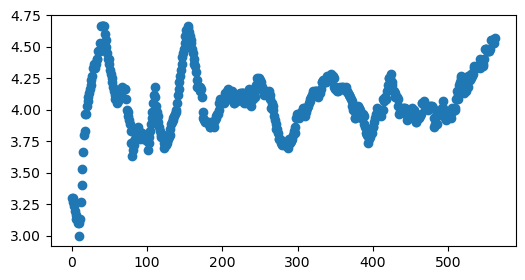

In [38]:
window = 30
j = window - 1
moving_avg = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_avg.append(np.mean(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_avg)    
#ax.set(ylim=(0, 0.000025))

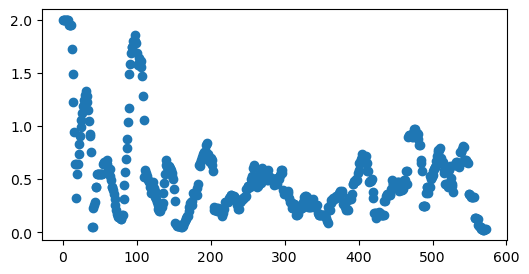

In [39]:
window = 20
j = window - 1
moving_var = []
df_score = attractions_df.sort_values('review_count_A', ascending = True)
df_score = df_score[df_score["review_count_A"] > 0]
idx = range(0, len(df_score))
for i in idx:
    moving_var.append(np.var(df_score.score_A[i:window]))
    window += 1
    if window > len(idx):
        break

fig, ax = plt.subplots(figsize = (6, 3))
#ax.set_xscale("log")
ax.scatter(idx[:-j], moving_var)    
#ax.set(ylim=(0, 0.000025))

In [40]:
# Calculating Bayesian Average for attractions
#m = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
#C = 100
#attractions_df["Bayesian_avg_A"] = ((attractions_df.score_A * attractions_df.review_count_A) 
#                                  + (C * m)) / (C + attractions_df.review_count_A)

S = np.mean(attractions_df.score_A[attractions_df["score_A"] > 0])
m_avg = np.mean(attractions_df.review_count_A[attractions_df["score_A"] > 0])

attractions_df["Bayesian_avg_A"] = (attractions_df.review_count_A/(attractions_df.review_count_A + m_avg)) * attractions_df.score_A +\
                                (m_avg/(attractions_df.review_count_A + m_avg)) * S
attractions_df = attractions_df[(attractions_df.score_A > 0) & (attractions_df.review_count_A > 0)]
print("Number of attractions: ", len(attractions_df))
attractions_df.head(10)

Number of attractions:  592


gcode_A    dcode_A                                             name_A  \
0  g187785   d2161503                                 Galleria Borbonica   
1  g187785    d243315                           Catacombe di San Gennaro   
2  g187785   d4063391                          Catacombe di San Gaudioso   
3  g187785  d10025055                         Museo delle Arti Sanitarie   
4  g187785   d3580580  Parco Archeologico Pausilypon - World Heritage...   
5  g187785  d12396492                                       Napulitanata   
6  g187785    d195431  SantAnna dei Lombardi (Monteoliveto) - World H...   
7  g187785  d16878926           Chiesa Museo di Santa Luciella ai Librai   
8  g187785   d3398103  MUSA - Museo Universitario delle Scienze e del...   
9  g187785   d2100869              La Chiesa Di San Giovanni A Carbonara   

   score_A  review_count_A        x_A        y_A  istat_pro_com_A  \
0      5.0           10365  14.246260  40.835520            63049   
1      5.0            5680  14.247445  40.865059            63049   
2      5.0            1659  14.249435  40.859502            63049   
3      5.0            1002  14.254908  40.854090            63049   
4      5.0             981  14.176582  40.799774            63049   
5      5.0             933  14.250652  40.852951            63049   
6      5.0             873  14.250546  40.845287            63049   
7      5.0             860  14.257575  40.849505            63049   
8      5.0             714  14.255550  40.853351            63049   
9      5.0             574  14.262206  40.854873            63049   

  municipality_A  Bayesian_avg_A  
0         Napoli        4.975244  
1         Napoli        4.955772  
2         Napoli        4.863877  
3         Napoli        4.793913  
4         Napoli        4.790470  
5         Napoli        4.782153  
6         Napoli        4.770780  
7         Napoli        4.768158  
8         Napoli        4.733976  
9         Napoli        4.690174

In [41]:
# Getting the nearest node ids to each attraction

id_nearest_node_A, dist_A = ox.distance.nearest_nodes(G, attractions_df['x_A'], 
                                              attractions_df['y_A'], 
                                              return_dist=True)

print("Successful mapping: ", len(attractions_df) == len(id_nearest_node_A))


attractions_df.insert(7, "id_nearest_node_A", id_nearest_node_A)
attractions_df.insert(8, "x_nearest_node_A", 
                 np.float64(nodes.x[id_nearest_node_A]))
attractions_df.insert(9, "y_nearest_node_A", 
                 np.float64(nodes.y[id_nearest_node_A]))

attractions_df.head(3)

Successful mapping:  True


gcode_A   dcode_A                     name_A  score_A  review_count_A  \
0  g187785  d2161503         Galleria Borbonica      5.0           10365   
1  g187785   d243315   Catacombe di San Gennaro      5.0            5680   
2  g187785  d4063391  Catacombe di San Gaudioso      5.0            1659   

         x_A        y_A  id_nearest_node_A  x_nearest_node_A  \
0  14.246260  40.835520        11308084483         14.246211   
1  14.247445  40.865059        10837559380         14.247246   
2  14.249435  40.859502         2272682955         14.249568   

   y_nearest_node_A  istat_pro_com_A municipality_A  Bayesian_avg_A  
0         40.835659            63049         Napoli        4.975244  
1         40.865090            63049         Napoli        4.955772  
2         40.859413            63049         Napoli        4.863877

In [42]:
# Filtering top-k attractions based on Bayesian avg.
k = len(attractions_df[attractions_df.Bayesian_avg_A >= 4]) #150 #   len(attractions_df) 
top_k_A_df = attractions_df.sort_values('Bayesian_avg_A', ascending = False)[0:k]
top_k_A_df.reset_index(drop = True, inplace=True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

top_k_A_df[["name_A", "score_A", "review_count_A", "Bayesian_avg_A"]].head(10)

name_A  score_A  review_count_A  \
0                                 Galleria Borbonica      5.0           10365   
1                           Catacombe di San Gennaro      5.0            5680   
2                          Catacombe di San Gaudioso      5.0            1659   
3                         Museo delle Arti Sanitarie      5.0            1002   
4  Parco Archeologico Pausilypon - World Heritage...      5.0             981   
5                                       Napulitanata      5.0             933   
6  SantAnna dei Lombardi (Monteoliveto) - World H...      5.0             873   
7           Chiesa Museo di Santa Luciella ai Librai      5.0             860   
8  MUSA - Museo Universitario delle Scienze e del...      5.0             714   
9              La Chiesa Di San Giovanni A Carbonara      5.0             574   

   Bayesian_avg_A  
0        4.975244  
1        4.955772  
2        4.863877  
3        4.793913  
4        4.790470  
5        4.782153  
6        4.770780  
7        4.768158  
8        4.733976  
9        4.690174

#### Defining restaurants (destination nodes)

In [43]:
# Importing the complete restaurants dataset
restaurants_col_names = ["gcode_A", "dcode_A", "name_R", "score_R", "review_count_R", 
                         "x_R", "y_R", "istat_pro_com_R", "municipality_R"] 

restaurants_total = pd.read_excel("restaurant_dataset.xlsx", sheet_name = "restaurant_dataset_filtered", 
                                  names = restaurants_col_names)

restaurants_total.head(3)

gcode_A    dcode_A            name_R  score_R  review_count_R        x_R  \
0  g194659  d15656043          Al Gallo      2.0               2  11.794100   
1  g194659   d8752262          Al Viale      4.5              13  11.786176   
2  g194659   d6439949  Alibi CafÃ¨ Club      4.0              31  11.786168   

         y_R  istat_pro_com_R municipality_R  
0  45.375183            28001    Abano Terme  
1  45.356347            28001    Abano Terme  
2  45.356669            28001    Abano Terme

In [44]:
# Filtering restaurants by municipality
restaurants_df = restaurants_total.copy()
restaurants_df['in_bbox'] = restaurants_df.apply(lambda x: city_polygon.contains(Point(x.x_R, x.y_R)), axis=1)
restaurants_df = restaurants_df.loc[(restaurants_df.municipality_R == "Napoli") &
                                   (restaurants_df.in_bbox == True)].reset_index(drop=True)
restaurants_df.drop("in_bbox", axis=1, inplace=True)
restaurants_df.head(3)

gcode_A    dcode_A                        name_R  score_R  review_count_R  \
0  g187785   d3675611               ' Na Tarantella      4.0             124   
1  g187785  d13986019  10 Diego Vitagliano Pizzeria      4.0             905   
2  g187785   d7736389             1947 pizza fritta      4.5             942   

         x_R        y_R  istat_pro_com_R municipality_R  
0  14.227416  40.849346            63049         Napoli  
1  14.175711  40.817090            63049         Napoli  
2  14.263642  40.849487            63049         Napoli

Text(0, 0.5, 'review score')

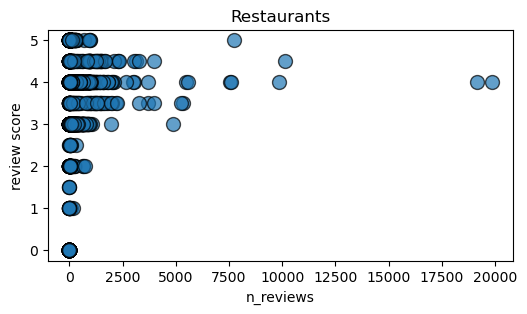

In [45]:
# Distribution of reviews as a function of number of reviews
# for the restaurants
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(restaurants_df["review_count_R"], restaurants_df["score_R"], 
           s=100, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_title("Restaurants")
ax.set_xlabel("n_reviews")
ax.set_ylabel("review score")

In [46]:
# Calculating Bayesian Average for restaurants
#m = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
#C = 100
#restaurants_df["Bayesian_avg_R"] = ((restaurants_df.score_R * restaurants_df.review_count_R) 
#                                  + (C * m)) / (C + restaurants_df.review_count_R)

S = np.mean(restaurants_df.score_R[restaurants_df["score_R"] > 0])
m_avg = np.mean(restaurants_df.review_count_R[restaurants_df["score_R"] > 0])

restaurants_df["Bayesian_avg_R"] = (restaurants_df.review_count_R/(restaurants_df.review_count_R + m_avg)) * restaurants_df.score_R +\
                                (m_avg/(restaurants_df.review_count_R + m_avg)) * S
restaurants_df = restaurants_df[(restaurants_df.score_R > 0) & (restaurants_df.review_count_R > 0)]
print("Number of restaurants: ", len(restaurants_df))
restaurants_df.head(3)

Number of restaurants:  2103


gcode_A    dcode_A                        name_R  score_R  review_count_R  \
0  g187785   d3675611               ' Na Tarantella      4.0             124   
1  g187785  d13986019  10 Diego Vitagliano Pizzeria      4.0             905   
2  g187785   d7736389             1947 pizza fritta      4.5             942   

         x_R        y_R  istat_pro_com_R municipality_R  Bayesian_avg_R  
0  14.227416  40.849346            63049         Napoli        3.875594  
1  14.175711  40.817090            63049         Napoli        3.957589  
2  14.263642  40.849487            63049         Napoli        4.344316

In [47]:
# Getting the nearest node ids to each restaurant

id_nearest_node_R, dist_R = ox.distance.nearest_nodes(G, restaurants_df['x_R'], 
                                              restaurants_df['y_R'], 
                                              return_dist=True)

print("Successful mapping: ", len(restaurants_df) == len(id_nearest_node_R))


restaurants_df.insert(7, "id_nearest_node_R", id_nearest_node_R)
restaurants_df.insert(8, "x_nearest_node_R", 
                 np.float64(nodes.x[id_nearest_node_R]))
restaurants_df.insert(9, "y_nearest_node_R", 
                 np.float64(nodes.y[id_nearest_node_R]))

restaurants_df

Successful mapping:  True


gcode_A    dcode_A                                   name_R  score_R  \
0     g187785   d3675611                          ' Na Tarantella      4.0   
1     g187785  d13986019             10 Diego Vitagliano Pizzeria      4.0   
2     g187785   d7736389                        1947 pizza fritta      4.5   
3     g187785   d2299303           21 Biergrube Ex KrÃ¼gel Vomero      3.5   
4     g187785  d10351179  CAFFETTERIA LA VELA SAS DI VELA CIRO EC      5.0   
...       ...        ...                                      ...      ...   
2299  g187785   d5888637                       DOLCEZZE SICILIANE      4.0   
2300  g187785  d20307953                           PIANO B CHIAIA      4.0   
2301  g187785   d4816545                            VILLA CILENTO      4.0   
2302  g187785  d17599430                      LOVEFOR NUâ€™ CAFÃˆ      2.0   
2303  g187785  d19176228                TRATTORIA LOCANDA BONANNO      5.0   

      review_count_R        x_R        y_R  id_nearest_node_R  \
0                124  14.227416  40.849346         4257788865   
1                905  14.175711  40.817090          301471023   
2                942  14.263642  40.849487         2907865598   
3               1232  14.214264  40.838330         2889232882   
4                 20  14.301530  40.843690         4961238753   
...              ...        ...        ...                ...   
2299              51  14.258629  40.842545         9056904237   
2300              11  14.234925  40.835964         3622284191   
2301              49  14.197064  40.806038         7787468228   
2302              20  14.244353  40.835957         3455678355   
2303             113  14.219362  40.878990         3505000931   

      x_nearest_node_R  y_nearest_node_R  istat_pro_com_R municipality_R  \
0            14.227476         40.849287            63049         Napoli   
1            14.175882         40.816990            63049         Napoli   
2            14.263541         40.849607            63049         Napoli   
3            14.214233         40.838077            63049         Napoli   
4            14.301407         40.843796            63049         Napoli   
...                ...               ...              ...            ...   
2299         14.258551         40.842554            63049         Napoli   
2300         14.234671         40.835908            63049         Napoli   
2301         14.196763         40.806928            63049         Napoli   
2302         14.244763         40.835817            63049         Napoli   
2303         14.219993         40.878353            63049         Napoli   

      Bayesian_avg_R  
0           3.875594  
1           3.957589  
2           4.344316  
3           3.559346  
4           3.899136  
...              ...  
2299        3.848155  
2300        3.827281  
2301        3.847232  
2302        3.699116  
2303        4.159667  

[2103 rows x 13 columns]

In [48]:
# Filtering top-k restaurants based on Bayesian avg.
k = len(restaurants_df[restaurants_df.Bayesian_avg_R >= 4]) #700 #  len(restaurants_df)
top_k_R_df = restaurants_df.sort_values('Bayesian_avg_R', ascending = False)[0:k]
top_k_R_df.reset_index(drop = True)

#fig, ax = plt.subplots(figsize = (8, 6))
#ax.scatter(np.arange(1, 376 , dtype=int), top_k_A_df.Bayesian_avg) 

gcode_A    dcode_A                             name_R  score_R  \
0    g187785   d3741499        Hachi Ristorante Giapponese      5.0   
1    g187785  d15143720                          Januarius      5.0   
2    g187785   d4318643           RE PAZZO - PIZZA & SFIZI      5.0   
3    g187785  d19880248               PIZZERIA SPERANZELLA      5.0   
4    g187785  d15273321                PIZZERIA CICCIO FRI      5.0   
..       ...        ...                                ...      ...   
106  g187785  d10455024           Little Square Pub & Beer      4.5   
107  g187785  d19749594             CRUDO COTTO E MANGIATO      5.0   
108  g187785  d11644210  O' Cuzzetiello Panineria TakeAway      4.5   
109  g187785   d8059158                   PIZZERIA SAMUELE      5.0   
110  g187785   d8096628                LA TAVERNA DI SASÃ€      5.0   

     review_count_R        x_R        y_R  id_nearest_node_R  \
0              7757  14.228222  40.843258           25366348   
1               986  14.259101  40.852280         2761852167   
2               967  14.276415  40.846767         8463645092   
3               932  14.247374  40.838287         2209901349   
4               681  14.246211  40.841362         3837365563   
..              ...        ...        ...                ...   
106             114  14.218608  40.860577          434604794   
107              55  14.266242  40.850395         3304664915   
108             108  14.274899  40.857536          224822157   
109              52  14.294456  40.860010         4949499837   
110              52  14.256757  40.843410         1936597513   

     x_nearest_node_R  y_nearest_node_R  istat_pro_com_R municipality_R  \
0           14.228193         40.843592            63049         Napoli   
1           14.258765         40.851767            63049         Napoli   
2           14.276283         40.846530            63049         Napoli   
3           14.247374         40.838375            63049         Napoli   
4           14.246234         40.841368            63049         Napoli   
..                ...               ...              ...            ...   
106         14.218702         40.860487            63049         Napoli   
107         14.266266         40.850519            63049         Napoli   
108         14.275174         40.857313            63049         Napoli   
109         14.294645         40.860032            63049         Napoli   
110         14.256834         40.843331            63049         Napoli   

     Bayesian_avg_R  
0          4.958912  
1          4.739152  
2          4.735178  
3          4.727530  
4          4.656362  
..              ...  
106        4.017118  
107        4.014163  
108        4.009650  
109        4.005254  
110        4.005254  

[111 rows x 13 columns]

#### Defining metro stations (destination nodes)

In [49]:
# Retrieving METRO (tram variable name is kept from previous city) stations nodes
tram_df = ox.features.features_from_place(place, {'railway': 'station', 'subway': 'yes'}, which_result=None, buffer_dist=None)
tram_df = tram_df.drop_duplicates(subset=['name'], keep='first')
tram_df["x_M"] = tram_df.geometry.get_coordinates()["x"]
tram_df["y_M"] = tram_df.geometry.get_coordinates()["y"]
tram_df.drop(["wheelchair", "operator", "wikidata", "wikipedia", "geometry", "network", "public_transport"
              , "train", "level", "light_rail", "note", "railway", "start_date", 
             "funicular", "short_name", "platforms", "wikimedia_commons", "source", "layer", 
             "construction:public_transport", "website", "nodes", "construction:railway", "building", 
             "area", "ref", "tunnel", "barrier", "station", "subway"], axis = 1, inplace = True)
#tram_df.drop(["bench", "bin", "internet_access", "internet_access:fee", "internet_access:operator", 
#             "lit", "public_transport", "railway", "shelter", "tactile_paving", "tram", 
#             "wheelchair", "geometry"], axis = 1, inplace = True)

tram_df.rename(columns={"name": "name_M"}, inplace = True)

In [50]:
# Source: https://www.metropolitanadinapoli.it/linea-6-metropolitana-di-napoli/
Napoli_stations = [
    "Piscinola-Scampia",
    "Chiaiano",
    "Frullone",
    "Colli Aminei",
    "Policlinico",
    "Rione Alto",
    "Montedonzelli",
    "Medaglie d'Oro",
    "Vanvitelli",
    "Quattro Giornate",
    "Salvator Rosa",
    "Materdei",
    "Museo",
    "Dante",
    "Toledo",
    "Municipio",
    "Università",
    "Garibaldi",
    "Mergellina",
    "Lala",
    "Augusto",
    "Mostra", 
    "Duomo"
]

tram_df = tram_df[tram_df['name_M'].isin(Napoli_stations)]

In [51]:
# Reset index
tram_df.reset_index(drop=True, inplace = True)

# Checking if the stations are inside the city
tram_df['in_bbox'] = tram_df.apply(lambda x: city_polygon.contains(Point(x.x_M, x.y_M)), axis=1)
tram_df = tram_df.loc[tram_df.in_bbox == True].reset_index(drop=True)
tram_df.drop("in_bbox", axis=1, inplace=True)

print("Number of Metro/Tram Stations/Stops: ", len(tram_df))
tram_df

Number of Metro/Tram Stations/Stops:  23


name_M        x_M        y_M
0            Chiaiano  14.223476  40.890712
1          Vanvitelli  14.231745  40.843919
2    Quattro Giornate  14.225124  40.846337
3            Materdei  14.242313  40.855058
4               Museo  14.251697  40.853424
5               Dante  14.250120  40.848942
6       Montedonzelli  14.225026  40.855950
7   Piscinola-Scampia  14.239836  40.892940
8                Lala  14.204566  40.826819
9          Mergellina  14.217367  40.830597
10            Augusto  14.198317  40.826185
11         Università  14.255516  40.843594
12           Frullone  14.230883  40.880750
13             Toledo  14.248874  40.842437
14              Duomo  14.261608  40.847617
15        Policlinico  14.221345  40.865244
16       Colli Aminei  14.228614  40.869813
17         Rione Alto  14.220230  40.861170
18     Medaglie d'Oro  14.230809  40.850560
19          Garibaldi  14.270042  40.851892
20             Mostra  14.193656  40.824337
21      Salvator Rosa  14.236764  40.851551
22          Municipio  14.252434  40.839742

In [52]:
# Getting the nearest node ids to each tram station

id_nearest_node_M, dist_M = ox.distance.nearest_nodes(G, tram_df['x_M'], 
                                              tram_df['y_M'], 
                                              return_dist=True)

print("Successful mapping: ", len(tram_df) == len(id_nearest_node_M))


tram_df.insert(len(tram_df.columns), "id_nearest_node_M", id_nearest_node_M)
tram_df.insert(len(tram_df.columns), "x_nearest_node_M", 
                 np.float64(nodes.x[id_nearest_node_M]))
tram_df.insert(len(tram_df.columns), "y_nearest_node_M", 
                 np.float64(nodes.y[id_nearest_node_M]))

tram_df

Successful mapping:  True


C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


name_M        x_M        y_M  id_nearest_node_M  \
0            Chiaiano  14.223476  40.890712        11494391846   
1          Vanvitelli  14.231745  40.843919          324621070   
2    Quattro Giornate  14.225124  40.846337        11495534852   
3            Materdei  14.242313  40.855058         4155755042   
4               Museo  14.251697  40.853424         4320624023   
5               Dante  14.250120  40.848942        11495610008   
6       Montedonzelli  14.225026  40.855950          434504493   
7   Piscinola-Scampia  14.239836  40.892940         8857482820   
8                Lala  14.204566  40.826819         2340730460   
9          Mergellina  14.217367  40.830597         3635585506   
10            Augusto  14.198317  40.826185         2684339144   
11         Università  14.255516  40.843594         4940774333   
12           Frullone  14.230883  40.880750        11494373608   
13             Toledo  14.248874  40.842437         5292237490   
14              Duomo  14.261608  40.847617         8667108987   
15        Policlinico  14.221345  40.865244         9622348272   
16       Colli Aminei  14.228614  40.869813         4975359531   
17         Rione Alto  14.220230  40.861170        11494960690   
18     Medaglie d'Oro  14.230809  40.850560         5378256085   
19          Garibaldi  14.270042  40.851892         9070364950   
20             Mostra  14.193656  40.824337         6844222496   
21      Salvator Rosa  14.236764  40.851551        10853438042   
22          Municipio  14.252434  40.839742         8651226935   

    x_nearest_node_M  y_nearest_node_M  
0          14.223367         40.890672  
1          14.231734         40.844054  
2          14.224993         40.846190  
3          14.242351         40.855250  
4          14.251731         40.853433  
5          14.249948         40.848957  
6          14.224702         40.855853  
7          14.239968         40.892926  
8          14.204831         40.826949  
9          14.218056         40.830494  
10         14.198839         40.826240  
11         14.255368         40.843525  
12         14.230996         40.880689  
13         14.248862         40.842427  
14         14.261791         40.847509  
15         14.221137         40.865216  
16         14.228492         40.869267  
17         14.220307         40.861055  
18         14.230768         40.850586  
19         14.270080         40.851712  
20         14.193325         40.824352  
21         14.236767         40.851526  
22         14.252223         40.839866

#### Defining walking speed

In [53]:
# Defining walking speed
speed_ms = 1 # In m/s
speed_mm = speed_ms * 60 # In m/min

#### Creating the combination of each Hotel to each Attraction to calculate Shortest Paths

In [54]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_A_df['_key'] = 1

# Performing the cross join to obtain Hotels-Attractions Data Frame
H_A_df = pd.merge(hotels_df, top_k_A_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_A_df = top_k_A_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_A_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_A_df["id_nearest_node_H"], H_A_df["id_nearest_node_A"], 
                      imp_name="length")

H_A_df["SP_dist_minutes"] = H_A_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_A_df["GC_dist_meters"] = ox.distance.great_circle(H_A_df.x_nearest_node_H, H_A_df.y_nearest_node_H, 
                                                    H_A_df.x_nearest_node_A, H_A_df.y_nearest_node_A)

# Rearranging DataFrame
H_A_df.insert(0, "name_H", H_A_df.pop("name_H"))
H_A_df.insert(1, "name_A", H_A_df.pop("name_A"))
H_A_df.insert(2, "SP_dist_minutes", H_A_df.pop("SP_dist_minutes"))

In [55]:
H_A_df.sort_values("SP_dist_minutes", ascending = False).head(10)

name_H  \
107261                              Montespina Park Hotel   
67197                             Hotel Fiorentina Napoli   
107287                              Montespina Park Hotel   
107294                              Montespina Park Hotel   
127248  Palazzo Argenta, Sure Hotel Collection By Best...   
107593                              Montespina Park Hotel   
107328                              Montespina Park Hotel   
41800                                         Hotel NuvÃ²   
60705                                        Le CheminÃ©e   
109395                                   Bed and Boarding   

                                 name_A  SP_dist_minutes  gcode_H    dcode_H  \
107261                Parco dei Murales       288.590933  g187785    d236480   
67197        Parco Letterario di Nisida       275.901917  g187785   d8484373   
107287  Basilica Santa Maria della Neve       275.243833  g187785    d236480   
107294                   Tennis Atheneo       273.999850  g187785    d236480   
127248       Parco Letterario di Nisida       272.723433  g187785  d17577296   
107593        Centro Commerciale Auchan       268.908150  g187785    d236480   
107328              Museo Masseria Luce       264.325833  g187785    d236480   
41800                 Parco dei Murales       264.032467  g187785   d2506869   
60705        Parco Letterario di Nisida       263.039617  g187785    d598839   
109395       Parco Letterario di Nisida       261.197983  g187785  d12179538   

        score_H  review_count_H        x_H        y_H  id_nearest_node_H  ...  \
107261      4.0             837  14.164062  40.824385         4207561789  ...   
67197       4.0              68  14.256944  40.896389         4958410700  ...   
107287      4.0             837  14.164062  40.824385         4207561789  ...   
107294      4.0             837  14.164062  40.824385         4207561789  ...   
127248      4.5              58  14.263446  40.890268          418012591  ...   
107593      4.0             837  14.164062  40.824385         4207561789  ...   
107328      4.0             837  14.164062  40.824385         4207561789  ...   
41800       4.5            1579  14.175725  40.817151          301471023  ...   
60705       4.0             413  14.297369  40.869253        10066790983  ...   
109395      3.5             121  14.284347  40.876352         2949283048  ...   

              x_A        y_A  id_nearest_node_A x_nearest_node_A  \
107261  14.340444  40.858419         9392736650        14.339749   
67197   14.166478  40.796349         1446117593        14.166166   
107287  14.331956  40.854630         1332450522        14.331757   
107294  14.305881  40.882624         1782450294        14.306874   
127248  14.166478  40.796349         1446117593        14.166166   
107593  14.328618  40.858337         4948921617        14.328777   
107328  14.289966  40.893404          977808029        14.289874   
41800   14.340444  40.858419         9392736650        14.339749   
60705   14.166478  40.796349         1446117593        14.166166   
109395  14.166478  40.796349         1446117593        14.166166   

        y_nearest_node_A istat_pro_com_A  municipality_A  Bayesian_avg_A  \
107261         40.858474           63049          Napoli        4.072744   
67197          40.796723           63049          Napoli        4.086147   
107287         40.854456           63049          Napoli        4.062296   
107294         40.881759           63049          Napoli        4.060062   
127248         40.796723           63049          Napoli        4.086147   
107593         40.858418           63049          Napoli        4.035211   
107328         40.893244           63049          Napoli        4.053306   
41800          40.858474           63049          Napoli        4.072744   
60705          40.796723           63049          Napoli        4.086147   
109395         40.796723           63049          Napoli        4.086147   

        SP_dist_mete

#### Creating the combination of each Hotel to each Restaurant to calculate Shortest Paths

In [56]:
# Creating keys for cross join
hotels_df['_key'] = 1 
top_k_R_df['_key'] = 1

# Performing the cross join to obtain Hotels-Restaurants Data Frame
H_R_df = pd.merge(hotels_df, top_k_R_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
top_k_R_df = top_k_R_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_R_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_R_df["id_nearest_node_H"], H_R_df["id_nearest_node_R"], 
                      imp_name="length")

H_R_df["SP_dist_minutes"] = H_R_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_R_df["GC_dist_meters"] = ox.distance.great_circle(H_R_df.x_nearest_node_H, H_R_df.y_nearest_node_H, 
                                                    H_R_df.x_nearest_node_R, H_R_df.y_nearest_node_R)

# Rearranging DataFrame
H_R_df.insert(0, "name_H", H_R_df.pop("name_H"))
H_R_df.insert(1, "name_R", H_R_df.pop("name_R"))
H_R_df.insert(2, "SP_dist_minutes", H_R_df.pop("SP_dist_minutes"))

In [57]:
H_R_df.sort_values("SP_dist_minutes", ascending = False).head(3)

name_H  \
26175  Palazzo Argenta, Sure Hotel Collection By Best...   
13854                            Hotel Fiorentina Napoli   
12520                                       Le CheminÃ©e   

                             name_R  SP_dist_minutes  gcode_H    dcode_H  \
26175             O' Pazz Posillipo       244.283550  g187785  d17577296   
13854             O' Pazz Posillipo       242.727617  g187785   d8484373   
12520  RISTO-PESCHERIA DA SALVATORE       235.474983  g187785    d598839   

       score_H  review_count_H        x_H        y_H  id_nearest_node_H  ...  \
26175      4.5              58  14.263446  40.890268          418012591  ...   
13854      4.0              68  14.256944  40.896389         4958410700  ...   
12520      4.0             413  14.297369  40.869253        10066790983  ...   

             x_R        y_R  id_nearest_node_R x_nearest_node_R  \
26175  14.187008  40.802990         2609884931        14.187263   
13854  14.187008  40.802990         2609884931        14.187263   
12520  14.168944  40.856323          926204496        14.168874   

       y_nearest_node_R istat_pro_com_R  municipality_R  Bayesian_avg_R  \
26175         40.802757           63049          Napoli        4.080014   
13854         40.802757           63049          Napoli        4.080014   
12520         40.856176           63049          Napoli        4.097669   

       SP_dist_meters  GC_dist_meters  
26175       14657.013    12677.914387  
13854       14563.657    12734.209718  
12520       14128.499    14397.774870  

[3 rows x 37 columns]

#### Creating the combination of each Hotel to each Metro/Tram Station/Stop to calculate Shortest Paths

In [58]:
# Creating keys for cross join
hotels_df['_key'] = 1 
tram_df['_key'] = 1

# Performing the cross join to obtain Hotels-Tram Stops Data Frame
H_M_df = pd.merge(hotels_df, tram_df, on='_key').drop('_key', axis=1)
hotels_df = hotels_df.drop("_key", axis=1)
tram_df = tram_df.drop("_key", axis=1)

# Calculating shortest paths in meters and minutes
H_M_df["SP_dist_meters"] = G_pdna.shortest_path_lengths(H_M_df["id_nearest_node_H"], H_M_df["id_nearest_node_M"], 
                      imp_name="length")

H_M_df["SP_dist_minutes"] = H_M_df["SP_dist_meters"] / speed_mm

# Calculating Great Circle distance in meters
H_M_df["GC_dist_meters"] = ox.distance.great_circle(H_M_df.x_nearest_node_H, H_M_df.y_nearest_node_H, 
                                                    H_M_df.x_nearest_node_M, H_M_df.y_nearest_node_M)

# Rearranging DataFrame
H_M_df.insert(0, "name_H", H_M_df.pop("name_H"))
H_M_df.insert(1, "name_M", H_M_df.pop("name_M"))
H_M_df.insert(2, "SP_dist_minutes", H_M_df.pop("SP_dist_minutes"))

In [59]:
# Keeping the closest tram stop, and adding a binary variable
H_M_df = H_M_df.sort_values("SP_dist_minutes", ascending = True).drop_duplicates(['name_H'])
H_M_df["Metro_Tram_stop"] = [1 if x <= X_minutes else 0 for x in H_M_df['SP_dist_minutes']]
H_M_df.reset_index(drop=True, inplace=True)
H_M_df

name_H      name_M  SP_dist_minutes  gcode_H    dcode_H  \
0       Relais Castel Nuovo   Municipio         0.000000  g187785  d12859680   
1    Amadomus Luxury Suites       Duomo         0.357000  g187785  d17555747   
2         Dimora San Felice  Università         0.529900  g187785  d12292268   
3               Bovio Suite  Università         0.529900  g187785    d307897   
4       Residenza Borbonica      Toledo         0.656317  g187785  d12884916   
..                      ...         ...              ...      ...        ...   
238   Montespina Park Hotel      Mostra        53.731367  g187785    d236480   
239           Hotel Joyfull   Garibaldi        56.164700  g187785    d622723   
240             Buono Hotel   Garibaldi        60.781267  g187785    d642959   
241            Le CheminÃ©e   Garibaldi        63.779183  g187785    d598839   
242        Bed and Boarding   Garibaldi        67.345083  g187785  d12179538   

     score_H  review_count_H        x_H        y_H  id_nearest_node_H  ...  \
0        5.0             253  14.252366  40.839792         8651226935  ...   
1        5.0             115  14.261671  40.847335         8667108969  ...   
2        4.5             101  14.254899  40.843716         2685916766  ...   
3        4.0             216  14.254968  40.843320         2685916766  ...   
4        5.0              70  14.249016  40.842369        11495638262  ...   
..       ...             ...        ...        ...                ...  ...   
238      4.0             837  14.164062  40.824385         4207561789  ...   
239      3.5             269  14.296834  40.864852         1332450593  ...   
240      4.0             208  14.295888  40.868362          235584987  ...   
241      4.0             413  14.297369  40.869253        10066790983  ...   
242      3.5             121  14.284347  40.876352         2949283048  ...   

     location_score  Bayesian_avg_H        x_M        y_M  id_nearest_node_M  \
0               4.9        4.608589  14.252434  40.839742         8651226935   
1               4.9        4.517437  14.261608  40.847617         8667108987   
2               4.9        4.418476  14.255516  40.843594         4940774333   
3               4.6        4.276278  14.255516  40.843594         4940774333   
4               4.9        4.477779  14.248874  40.842437         5292237490   
..              ...             ...        ...        ...                ...   
238             3.6        4.145765  14.193656  40.824337         6844222496   
239             2.2        4.076508  14.270042  40.851892         9070364950   
240             3.2        4.279501  14.270042  40.851892         9070364950   
241             2.9        4.215163  14.270042  40.851892         9070364950   
242             4.9        4.219052  14.270042  40.851892         9070364950   

    x_nearest_node_M  y_nearest_node_M  SP_dist_meters  GC_dist_meters  \
0          14.252223         40.839866           0.000        0.000000   
1          14.261791         40.847509          21.420       18.333031   
2          14.255368         40.843525          31.794       41.925202   
3          14.255368         40.843525          31.794       41.925202   
4          14.248862         40.842427          39.379        7.103068   
..               ...               ...             ...             ...   
238        14.193325         40.824352        3223.882     3269.674114   
239        14.270080         40.851712        3369.882     3294.691140   
240        14.270080         40.851712        3646.876     3414.520519   
241        14.270080         40.851712        3826.751     3624.679192   
242        14.270080         40.851712        4040.705     3085.295999   

     Metro_Tram_stop  
0                  1  
1                  1  
2                  1  
3                  1  
4                  1  
..               ...  
238                0  
239                0  
240                0  
241                0  
242                0

In [60]:
#nx.shortest_path_length(G, 343709332, 332103291, weight = "length") / speed_mm

In [61]:
# Metrics at X minutes distance for attractions

# X minutes level 1
A_lvl1 = pd.DataFrame(H_A_df.name_H[H_A_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(A_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.hotel_class.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == A_lvl1.index[i]])

    
A_lvl1.insert(1, "hotel_class", np.float64(hotel_name_list_lvl1))
A_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
A_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
A_lvl1

count  Bayes_avg_H  \
name_H                                                                   
Cloister inn                                          181     4.475865   
Decumani Hotel de Charme                              180     4.484538   
Hotel Piazza Bellini & Apartments                     171     4.486472   
OVO - Slow Travel                                     171     4.411600   
Napoli Pietrasanta locazione breve di F. Silvestro    168     4.507462   
...                                                   ...          ...   
Palazzo Esedra                                          2     4.169939   
Buono Hotel                                             1     4.279501   
Hotel Cristina                                          1     4.479848   
Holiday Inn Naples, an IHG hotel                        1     3.685473   
Le CheminÃ©e                                            1     4.215163   

                                                    review_count_H  \
name_H                                                               
Cloister inn                                                  68.0   
Decumani Hotel de Charme                                    2573.0   
Hotel Piazza Bellini & Apartments                           3009.0   
OVO - Slow Travel                                             56.0   
Napoli Pietrasanta locazione breve di F. Silvestro           103.0   
...                                                            ...   
Palazzo Esedra                                               650.0   
Buono Hotel                                                  208.0   
Hotel Cristina                                              1863.0   
Holiday Inn Naples, an IHG hotel                            1843.0   
Le CheminÃ©e                                                 413.0   

                                                    hotel_class  
name_H                                                           
Cloister inn                                                3.0  
Decumani Hotel de Charme                                    4.0  
Hotel Piazza Bellini & Apartments                           3.0  
OVO - Slow Travel                                           3.0  
Napoli Pietrasanta locazione breve di F. Silvestro          3.0  
...                                                         ...  
Palazzo Esedra                                              4.0  
Buono Hotel                                                 3.0  
Hotel Cristina                                              3.0  
Holiday Inn Naples, an IHG hotel                            4.0  
Le CheminÃ©e                                                4.0  

[237 rows x 4 columns]

In [62]:
# Metrics at X minutes distance for restaurants

# X minutes level 1
R_lvl1 = pd.DataFrame(H_R_df.name_H[H_R_df["SP_dist_minutes"] <= X_minutes].value_counts())

hotel_name_list_lvl1 = []
hotel_n_reviews_list_lvl1 = []
Bayes_avg_list_H_lvl1 = []

for i in range(0, len(R_lvl1)):
    hotel_name_list_lvl1.append(hotels_df.hotel_class.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    hotel_n_reviews_list_lvl1.append(hotels_df.review_count_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])
    Bayes_avg_list_H_lvl1.append(hotels_df.Bayesian_avg_H.loc[hotels_df["name_H"] == R_lvl1.index[i]])

    
R_lvl1.insert(1, "hotel_class", np.float64(hotel_name_list_lvl1))
R_lvl1.insert(1, "review_count_H", np.float64(hotel_n_reviews_list_lvl1))
R_lvl1.insert(1, "Bayes_avg_H", np.float64(Bayes_avg_list_H_lvl1))
R_lvl1

count  Bayes_avg_H  review_count_H  hotel_class
name_H                                                                      
NH Napoli Panorama              39     3.612360          3353.0          4.0
Fiorentini Residence Napoli     39     4.425787           158.0          3.0
iBed Napoli                     39     4.642813           323.0          1.0
Grand Hotel Oriente             38     4.484343          2535.0          4.0
B&B Via Toledo 156              38     4.671156           392.0          3.0
...                            ...          ...             ...          ...
Ausonia Bed & Breakfast          1     4.345525            77.0          3.0
Hotel Joyfull                    1     4.076508           269.0          3.0
Naples Experience Hostel         1     4.426366           163.0          3.0
Hotel Cristina                   1     4.479848          1863.0          3.0
Grand Hotel Parker's             1     4.085256          1770.0          5.0

[227 rows x 4 columns]

# FOR JUPYTER LAB

test_map = keplergl.KeplerGl()

df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count = []
for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count.append(0)
df.insert(len(df.columns), "Count", df_Count)
test_map.add_data(data=df)

#test_map.add_data(data=counts_H)


orig_html = str(test_map._repr_html_(),'utf-8')

better_html = orig_html
b64 = base64.b64encode(better_html.encode('utf-8'))
src = f"data:text/html;base64,{b64.decode('utf-8')}"
base64d_html = f'<iframe src="{src}" style="width:100%; height: 400px">'
IPython.display.HTML(base64d_html)

In [63]:
# KeplerGL config

kepler_config = {'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [184, 110, 218],
        'size': 11,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'csiktu',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_TWI',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'TWI', 'type': 'real'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'ifo3kcp',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_points_Walkability_num',
      'color': [231, 159, 213],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 8,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [173, 185, 51],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Walkability_num',
       'type': 'integer'},
      'colorScale': 'quantize',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '3tag46c',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_A', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_A', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'aw0qhcc',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_count',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Count_R', 'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Count_R', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': 'pmgr4v',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_M_binary',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Metro_Tram_stop',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Metro_Tram_stop', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '76hrvw',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_A_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Attractions',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'aqi7i2u',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_R_Closeness',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#99FF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [0, 500],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'sum',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Closeness_Centrality_Restaurants',
       'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': 'qy3pmbe',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_class',
      'color': [246, 209, 138],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000', '#FF6600', '#FFCC00', '#CCFF00', '#00FF00']},
       'coverage': 1,
       'sizeRange': [200, 600],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 1,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantize',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'd9bu4gf',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_score',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Score_H', 'type': 'real'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Score_H', 'type': 'real'},
      'sizeScale': 'linear'}},
    {'id': '6r22q1w',
     'type': 'grid',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_review_count',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 1,
       'worldUnitSize': 0.025,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'coverage': 1,
       'sizeRange': [20, 300],
       'percentile': [0, 100],
       'elevationPercentile': [0, 100],
       'elevationScale': 5,
       'enableElevationZoomFactor': True,
       'colorAggregation': 'average',
       'sizeAggregation': 'average',
       'enable3d': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Review_count_H',
       'type': 'integer'},
      'colorScale': 'quantize',
      'sizeField': {'name': 'Review_count_H', 'type': 'integer'},
      'sizeScale': 'linear'}},
    {'id': '2sol0j',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_3D_Bayes_Avg',
      'color': [30, 150, 190],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': True,
      'visConfig': {'radius': 10,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 8],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_H',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '6g29u9r',
     'type': 'heatmap',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels_heat_map',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude'},
      'isVisible': False,
      'visConfig': {'opacity': 0.8,
       'colorRange': {'name': 'ColorBrewer RdYlGn-10',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#a50026',
         '#d73027',
         '#f46d43',
         '#fdae61',
         '#fee08b',
         '#d9ef8b',
         '#a6d96a',
         '#66bd63',
         '#1a9850',
         '#006837']},
       'radius': 100},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'weightField': None, 'weightScale': 'linear'}},
    {'id': '2jqr7zb',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Attractions',
      'color': [36, 115, 189],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [72, 43, 189],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [66, 101, 204],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'se4ty0m',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Restaurants',
      'color': [218, 0, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [240, 237, 234],
        'size': 8,
        'offset': [0, 0],
        'anchor': 'middle',
        'alignment': 'bottom'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'o69bpud',
     'type': 'point',
     'config': {'dataId': 'Metro/Tram',
      'label': 'Metro/Tram Stops',
      'color': [214, 160, 0],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 0.8,
       'outline': False,
       'thickness': 2,
       'strokeColor': [30, 150, 190],
       'colorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': {'name': 'Tram Stop name', 'type': 'string'},
        'color': [185, 118, 0],
        'size': 10,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': None,
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'pj7phwm',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'price',
      'color': [34, 63, 154],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#00FF00', '#CCFF00', '#FFCC00', '#FF6600', '#FF0000'],
        'reversed': True},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'price', 'type': 'integer'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': 'mxggy1p',
     'type': 'point',
     'config': {'dataId': 'Attractions',
      'label': 'Bayes Attractions',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_A',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}},
    {'id': '79yotqi',
     'type': 'point',
     'config': {'dataId': 'Restaurants',
      'label': 'Bayes Restaurants',
      'color': [218, 112, 191],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude',
       'lng': 'Longitude',
       'altitude': 'Bayesian_avg_R'},
      'isVisible': False,
      'visConfig': {'radius': 10.4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': None,
       'colorRange': {'name': 'ColorBrewer RdYlGn-5',
        'type': 'diverging',
        'category': 'ColorBrewer',
        'colors': ['#d7191c', '#fdae61', '#ffffbf', '#a6d96a', '#1a9641']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',
         '#C70039',
         '#E3611C',
         '#F1920E',
         '#FFC300']},
       'radiusRange': [0, 50],
       'filled': True},
      'hidden': False,
      'textLabel': [{'field': None,
        'color': [255, 255, 255],
        'size': 18,
        'offset': [0, 0],
        'anchor': 'start',
        'alignment': 'center'}]},
     'visualChannels': {'colorField': {'name': 'Bayesian_avg_R',
       'type': 'real'},
      'colorScale': 'quantile',
      'strokeColorField': None,
      'strokeColorScale': 'quantile',
      'sizeField': None,
      'sizeScale': 'linear'}}],
   'interactionConfig': {'tooltip': {'fieldsToShow': {'unnamed': [{'name': 'Hotel name',
        'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None},
       {'name': 'Walkability_num', 'format': None}],
      'Attractions': [{'name': 'Attraction name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Restaurants': [{'name': 'Restaurant name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}],
      'Metro/Tram': [{'name': 'Tram Stop name', 'format': None},
       {'name': 'Longitude', 'format': None},
       {'name': 'Latitude', 'format': None}]},
     'compareMode': False,
     'compareType': 'absolute',
     'enabled': True},
    'brush': {'size': 0, 'enabled': False},
    'geocoder': {'enabled': False},
    'coordinate': {'enabled': False}},
   'layerBlending': 'normal',
   'splitMaps': [],
   'animationConfig': {'currentTime': None, 'speed': 1}},
  'mapState': {'bearing': 0,
   'dragRotate': False,
   'latitude': 40.844044666751145,
   'longitude': 14.255318488795316,
   'pitch': 0,
   'zoom': 11.36331618573136,
   'isSplit': False},
  'mapStyle': {'styleType': 'a0lwzne',
   'topLayerGroups': {},
   'visibleLayerGroups': {'label': False,
    'road': True,
    'building': True,
    'water': True,
    'land': True},
   'threeDBuildingColor': [9.665468314072013,
    17.18305478057247,
    31.1442867897876],
   'mapStyles': {'a0lwzne': {'accessToken': None,
     'custom': True,
     'icon': 'https://api.mapbox.com/styles/v1/mapbox/streets-v12/static/-122.3391,37.7922,9,0,0/400x300?access_token=pk.eyJ1IjoidWNmLW1hcGJveCIsImEiOiJja3RpeXhkaXcxNzJtMnZxbmtkcnJuM3BkIn0.kGmGlkbuWaCBf7_RrZXULg&logo=false&attribution=false',
     'id': 'a0lwzne',
     'label': 'Mapbox Streets',
     'url': 'mapbox://styles/mapbox/streets-v12'}}}}}

In [64]:
# Hotels
df = hotels_df[["name_H", "x_H", "y_H"]].copy()
df.rename(columns={"name_H": "Hotel name", "x_H": "Longitude", "y_H":"Latitude"}, inplace = True)
df_Count_A = []
df_Count_R = []
df_metro_tram_stop = []
df_CC_A = [] # Closeness centrality calculation to each Attraction node (every node)
df_CC_R = [] # Closeness centrality calculation to each Restaurant node (every node)
df_ST_A = [] # Directness calculation to each Attraction node (every node)
df_ST_R = [] # Directness calculation to each Restaurant node (every node)

for name in list(df["Hotel name"]):
    if name in A_lvl1.index:
        df_Count_A.append(A_lvl1.values[A_lvl1.index==name][0][0])
    else:
        df_Count_A.append(0)
    if name in R_lvl1.index:
        df_Count_R.append(R_lvl1.values[R_lvl1.index==name][0][0])
    else:
        df_Count_R.append(0)
    df_metro_tram_stop.append(H_M_df.Metro_Tram_stop[H_M_df.name_H == name].values[0])
    df_CC_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    df_CC_R.append(len(top_k_R_df)/np.sum(H_R_df.SP_dist_meters[H_R_df.name_H == name]))
    df_ST_A.append(len(top_k_A_df)/np.sum(H_A_df.SP_dist_meters[H_A_df.name_H == name]))
    
df.insert(len(df.columns), "Count_A", df_Count_A)
df.insert(len(df.columns), "Count_R", df_Count_R)
df.insert(len(df.columns), "Metro_Tram_stop", df_metro_tram_stop)
df.insert(len(df.columns), "Closeness_Centrality_Attractions", df_CC_A)
df.insert(len(df.columns), "Closeness_Centrality_Restaurants", df_CC_R)
df["Hotel_class"] = hotels_df.hotel_class[hotels_df["name_H"] == df["Hotel name"]]
df["Review_count_H"] = hotels_df.review_count_H[hotels_df["name_H"] == df["Hotel name"]]
df["Score_H"] = hotels_df.score_H[hotels_df["name_H"] == df["Hotel name"]]
df["Bayesian_avg_H"] = hotels_df.Bayesian_avg_H[hotels_df["name_H"] == df["Hotel name"]]
df["avg_price"] = hotels_df.avg_price[hotels_df["name_H"] == df["Hotel name"]]
df["avg_price_log"] = np.log(hotels_df.avg_price[hotels_df["name_H"] == df["Hotel name"]])
df["price_5_6_august"] = hotels_df.price_5_6_august[hotels_df["name_H"] == df["Hotel name"]]
df["price_range_min"] = hotels_df.price_range_min[hotels_df["name_H"] == df["Hotel name"]]
df["price_range_max"] = hotels_df.price_range_max[hotels_df["name_H"] == df["Hotel name"]]
df["location_score"] = hotels_df.location_score[hotels_df["name_H"] == df["Hotel name"]]
df["n_rooms"] = hotels_df.n_rooms[hotels_df["name_H"] == df["Hotel name"]]



# Attractions
df2 = top_k_A_df[["name_A", "x_A", "y_A", "Bayesian_avg_A"]].copy()
df2.rename(columns={"name_A": "Attraction name", "x_A": "Longitude", "y_A":"Latitude"}, inplace = True)

# Restaurants
df3 = top_k_R_df[["name_R", "x_R", "y_R", "Bayesian_avg_R"]].copy()
df3.rename(columns={"name_R": "Restaurant name", "x_R": "Longitude", "y_R":"Latitude"}, inplace = True)

# Metro/Tram
df4 = tram_df[["name_M", "x_M", "y_M"]].copy()
df4.rename(columns={"name_M": "Tram Stop name", "x_M": "Longitude", "y_M":"Latitude"}, inplace = True)

#### Tourism Walkability Index

In [65]:
# Three variables are going to be used for calculating the Tourism Walkability Index:
# Count of Attractions
# Count of Restaurants
# Average of Bayesian Score for Attractions and Restaurants

# Calculating the mean and std of each variable
mean_A = np.mean(df.Count_A)
std_A = np.std(df.Count_A)
mean_R = np.mean(df.Count_R)
std_R = np.std(df.Count_R)
#mean_BA = np.mean(top_k_A_df.Bayesian_avg_A)
#std_BA = np.std(top_k_A_df.Bayesian_avg_A)

mean_BA = np.mean(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
std_BA = np.std(H_A_df.Bayesian_avg_A[H_A_df["SP_dist_minutes"] <= X_minutes])
mean_BR = np.mean(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])
std_BR = np.std(H_R_df.Bayesian_avg_R[H_R_df["SP_dist_minutes"] <= X_minutes])

# Calculating Z-score for each hotel (standardization)
df["Count_A_Z"] = (df.Count_A - mean_A) / std_A
df["Count_R_Z"] = (df.Count_R - mean_R) / std_R
Bayes_mean_A = []
Bayes_mean_R = []
for name in hotels_df.name_H:
    Bayes_aux_A = np.mean(H_A_df.Bayesian_avg_A[(H_A_df["name_H"] ==  name) 
                                                    & (H_A_df["SP_dist_minutes"] <= X_minutes)])
    Bayes_aux_R = np.mean(H_R_df.Bayesian_avg_R[(H_R_df["name_H"] ==  name) 
                                                & (H_R_df["SP_dist_minutes"] <= X_minutes)])
    if np.isnan(Bayes_aux_A):
        Bayes_mean_A.append(0)
    else:
        Bayes_mean_A.append(Bayes_aux_A)
    if np.isnan(Bayes_aux_R):
        Bayes_mean_R.append(0)
    else:
        Bayes_mean_R.append(Bayes_aux_R)
df["Bayes_mean_A"] = Bayes_mean_A
df["Bayes_mean_R"] = Bayes_mean_R

In [66]:
# Defining index using "additive method" (weights can be defined in this step)

check_correlation = 0 # If 1, it looks for the combination that gives the best correlation, if 0, it continues with
# the predefined ones

if check_correlation == 1:
    # Looking for the highest correlation
    # Define the ranges for w1, w2, w3, and w4
    w1_range = np.arange(0, 5.1, 0.2)
    w2_range = np.arange(0, 5.1, 0.2)

    # Initialize variables to store the best correlation and the best weights
    best_corr = -1
    best_weights = (0, 0)

    # Iterate over all combinations of w1, w2, w3, and w4
    jj = 0
    for w1 in w1_range:
        for w2 in w2_range:
            for w3 in w3_range:
                for w4 in w4_range:
                    # Calculate the TWI for the current combination of weights
                    df["TWI"] = (w1 * df["Count_A_Z"] +
                                 w2 * df["Count_R_Z"])
                
                    # Calculate the Spearman correlation
                    corr, _ = pearsonr(df["location_score"], df["TWI"])
                
                    # Update the best correlation and weights if the current correlation is higher
                    if corr > best_corr:
                        best_corr = corr
                        best_weights = (w1, w2)
        jj+=1
        print(f"Iteration {jj}/{len(w1_range)}")
    print(f"Best Spearman correlation: {best_corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])

else:
    # Output the best correlation and the corresponding weights
    best_weights =  (2, 1) #(1.9, 2.3, 0, 0) # Considering all the attractions and restaurants: w1=0.0, w2=1.0, w3=4.6, w4=0.0 or (0.4, 2.2)
                    # Considering 150 att and 700 rest: (1.6, 1.8, 4.4, 0.0) or (1.9, 2.3)
    df["TWI"] = (best_weights[0] * df["Count_A_Z"] +
                best_weights[1] * df["Count_R_Z"])
    corr, _ = spearmanr(df["location_score"], df["TWI"])
    print(f"Best Spearman correlation: {corr}")
    print(f"Best weights: w1={best_weights[0]}, w2={best_weights[1]}")

# Scaling the index
a = 0 # Min value of the scale
b = 100 # Max value of the scale
df["TWI"] = a + ((df["TWI"] - np.min(df["TWI"])) * (b - a)) / (np.max(df["TWI"]) - np.min(df["TWI"]))

Best Spearman correlation: 0.5694163752725464
Best weights: w1=2, w2=1


Text(0, 0.5, 'TWI')

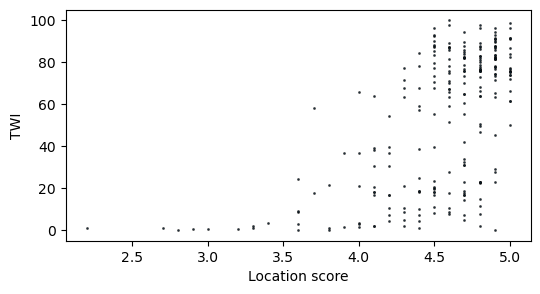

In [67]:
# Distribution of index as a function of location score
fig, ax = plt.subplots(figsize = (6, 3))
ax.scatter(df["location_score"], df["TWI"], 
           s=1, alpha=0.7, edgecolors="k")
#ax.set_xscale("log")
ax.set_xlabel("Location score")
ax.set_ylabel("TWI")

In [68]:
# Index interval classification
conditions = [
    (df['TWI'] > 20) & (df['TWI'] <= 40),
    (df['TWI'] > 40) & (df['TWI'] <= 60),
    (df['TWI'] > 60) & (df['TWI'] <= 80),
    (df['TWI'] > 80) & (df['TWI'] <= 100)]
choices_quali = ['Basic', 'Average', 'High', 'Excelent']
choices_quant = [2, 3, 4, 5]
df['Walkability'] = np.select(conditions, choices_quali, default='Poor')
df['Walkability_num'] = np.select(conditions, choices_quant, default=1)

df

Hotel name  Longitude   Latitude  Count_A  Count_R  \
0    Hotel San Francesco al Monte  14.243914  40.844309     55.0     16.0   
1                    Napoli Suite  14.258518  40.845644    146.0     23.0   
2               Hotel Il Convento  14.247444  40.838826     93.0     35.0   
3                  Hostel Mancini  14.266136  40.851876     67.0     11.0   
4                     Hotel NunÃ¹  14.259066  40.846157    144.0     23.0   
..                            ...        ...        ...      ...      ...   
238             Casa del Monacone  14.247190  40.859012     32.0      5.0   
239    B&B il Golfo Napoli Centro  14.269605  40.852372     25.0      8.0   
240        Palazzo Settembrini 49  14.259598  40.855385     98.0     10.0   
241              Sarracino Relais  14.257779  40.855303    123.0     12.0   
242                 Domus Armenio  14.259876  40.848876    139.0     19.0   

     Metro_Tram_stop  Closeness_Centrality_Attractions  \
0                  1                          0.000409   
1                  1                          0.000424   
2                  1                          0.000411   
3                  1                          0.000351   
4                  1                          0.000421   
..               ...                               ...   
238                1                          0.000345   
239                1                          0.000329   
240                1                          0.000361   
241                1                          0.000382   
242                1                          0.000405   

     Closeness_Centrality_Restaurants  Hotel_class  Review_count_H  ...  \
0                            0.000476          4.0            1268  ...   
1                            0.000445          3.0             487  ...   
2                            0.000511          3.0            1419  ...   
3                            0.000347          1.0             433  ...   
4                            0.000438          4.0             269  ...   
..                                ...          ...             ...  ...   
238                          0.000351          1.0             328  ...   
239                          0.000327          3.0             110  ...   
240                          0.000353          4.0              83  ...   
241                          0.000373          2.0              24  ...   
242                          0.000407          3.0             227  ...   

     price_range_max  location_score  n_rooms  Count_A_Z  Count_R_Z  \
0              330.0             4.4     45.0  -0.541738  -0.146213   
1              131.0             4.4      7.0   1.139353   0.437611   
2              256.0             4.7     14.0   0.160256   1.438452   
3              172.0             4.1     11.0  -0.320056  -0.563231   
4              297.0             4.5     13.0   1.102406   0.437611   
..               ...             ...      ...        ...        ...   
238            127.0             4.4      6.0  -0.966629  -1.063651   
239            112.0             4.5      5.0  -1.095944  -0.813441   
240            201.0             4.6     15.0   0.252624  -0.646634   
241            109.0             4.8      4.0   0.714462  -0.479827   
242            126.0             4.9      3.0   1.010038   0.103997   

     Bayes_mean_A  Bayes_mean_R        TWI  Walkability  Walkability_num  
0        4.108161      4.302240  38.909890        Basic                2  
1        4.110449      4.272844  84.517109     Excelent                5  
2        4.115174      4.329372  73.452201         High                4  
3        4.131221      4.272220  39.214410        Basic                2  
4        4.107063      4.272844  83.663055     Excelent                5  
..            ...           ...        ...          ...              ...  
238      4.154283      4.321177  18.484683         Poor                1  
239      4.087652      4.317400  18.387377     

<Axes: xlabel='Walkability', ylabel='Count'>

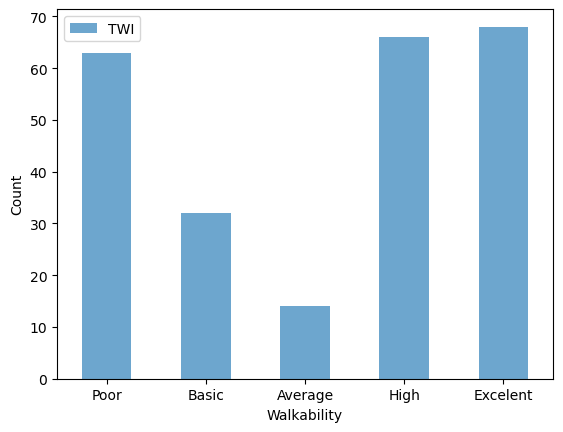

In [69]:
# Walkability index histogram
counts_for_plot = []
walkability_levels = ['Poor', 'Basic', 'Average', 'High', 'Excelent']
for i in walkability_levels:
    if i in df.Walkability.values:
        counts_for_plot.append(len(df[df.Walkability == i]))
    else:
        counts_for_plot.append(0)
pd.DataFrame({"Walkability":walkability_levels, "TWI":counts_for_plot}).plot.bar(x="Walkability", alpha=0.65, xlabel="Walkability", ylabel="Count", rot=0)

In [70]:
test_map = keplergl.KeplerGl(height = 800, config=kepler_config)

test_map.add_data(data=df)
test_map.add_data(data=df2, name="Attractions")
test_map.add_data(data=df3, name="Restaurants")
test_map.add_data(data=df4, name="Metro/Tram")
test_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


C:\Users\mario\anaconda3\Lib\site-packages\ipywidgets\widgets\widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
C:\Users\mario\anaconda3\Lib\site-packages\jupyter_client\session.py:718: UserWarning: Message seri

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '2fxa7ht', 'type': …

In [71]:
test_map.config

{'version': 'v1',
 'config': {'visState': {'filters': [],
   'layers': [{'id': '2fxa7ht',
     'type': 'point',
     'config': {'dataId': 'unnamed',
      'label': 'Hotels',
      'color': [184, 110, 218],
      'highlightColor': [252, 242, 26, 255],
      'columns': {'lat': 'Latitude', 'lng': 'Longitude', 'altitude': None},
      'isVisible': False,
      'visConfig': {'radius': 4,
       'fixedRadius': False,
       'opacity': 1,
       'outline': False,
       'thickness': 2,
       'strokeColor': [240, 237, 234],
       'colorRange': {'name': 'Custom Palette',
        'type': 'custom',
        'category': 'Custom',
        'colors': ['#FF0000',
         '#FF3300',
         '#FF6600',
         '#FF9900',
         '#FFCC00',
         '#CCFF00',
         '#99FF00',
         '#66FF00',
         '#33FF00',
         '#00FF00']},
       'strokeColorRange': {'name': 'Global Warming',
        'type': 'sequential',
        'category': 'Uber',
        'colors': ['#5A1846',
         '#900C3F',

In [72]:
# Saving the map to html
test_map.save_to_html(file_name='kepler_map_Napoli_hotel_15min.html')

Map saved to kepler_map_Napoli_hotel_15min.html!


In [79]:
df["TWI"].to_excel("TWI_hotels_Napoli.xlsx")

#### Price analysis

In [147]:
# Run this ONCE
df2 = df.copy()

In [148]:
df = df2

In [149]:
# Removing price outliers
Q1 = df['avg_price_log'].quantile(0.25)
Q3 = df['avg_price_log'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
df = df[(df['avg_price_log'] >= Q1 - 1.5 * IQR) & (df['avg_price_log'] <= Q3 + 1.5 *IQR)]

In [150]:
len(df)

233

In [151]:
df.Hotel_class = df.Hotel_class.astype(int)
df.Hotel_class.value_counts().sort_values()

C:\Users\mario\AppData\Local\Temp\ipykernel_21176\3655989462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.Hotel_class = df.Hotel_class.astype(int)


Hotel_class
5     10
1     14
2     27
4     52
3    130
Name: count, dtype: int64

In [152]:
# Creating quantiles (quartiles) for review_count_H and n_rooms
df["n_rooms_quant"] = pd.qcut(df.n_rooms, 4, labels=False)
#df["Review_count_H_quant"] = pd.qcut(df.Review_count_H, 4, labels=False)

C:\Users\mario\AppData\Local\Temp\ipykernel_21176\1898345718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["n_rooms_quant"] = pd.qcut(df.n_rooms, 4, labels=False)


In [153]:
# Get dummies
df_dummies = pd.get_dummies(df, columns = ["Hotel_class", "n_rooms_quant", "Walkability_num"], dtype = int)
df_dummies["Hotel_class_12"] = (df_dummies["Hotel_class_1"].apply(bool) | 
                                    df_dummies["Hotel_class_2"].apply(bool)).replace({True: 1, False: 0})
df_dummies["Hotel_class_45"] = (df_dummies["Hotel_class_4"].apply(bool) | 
                                    df_dummies["Hotel_class_5"].apply(bool)).replace({True: 1, False: 0})

C:\Users\mario\AppData\Local\Temp\ipykernel_21176\76144645.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies["Hotel_class_2"].apply(bool)).replace({True: 1, False: 0})
C:\Users\mario\AppData\Local\Temp\ipykernel_21176\76144645.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_dummies["Hotel_class_5"].apply(bool)).replace({True: 1, False: 0})


In [154]:
# Export the DataFrame to Excel file
#df_dummies.to_excel("Napoli_dataframe_stat_analysis.xlsx")

In [155]:
#df_dummies.n_rooms[df_dummies.n_rooms_quant_0 == 0].min()

In [156]:
df_dummies.drop(labels=["Walkability", 'Hotel name', "Longitude", "Latitude", "Count_A", "Count_R", 
                       "Count_A_Z", "Count_R_Z", "n_rooms", 
                       'Hotel_class_1', 'Hotel_class_2', 'Hotel_class_4', 'Hotel_class_5'], axis=1, inplace=True)

In [157]:
# For price analysis:
    # High correlation between TWI and both closeness centrality -> Use only TWI
    # Don't use review_count_h nor score_h as they are captured by Bayesian_avg_H -> Use only Bayesian_avg_H
    # -> n_rooms_quant_0, n_rooms_quant_1, n_rooms_quant_2, n_rooms_quant_3, Hotel_class_123, Hotel_class_45, Metro_Tram_stop
    # -> Bayesian_avg_mean_A_Z, Bayesian_avg_mean_R_Z, Metro_tram_stop
    
# Bayesian_avg_H analysis
    # Don't use review_count_h nor score_h as they are captured by Bayesian_avg_H
    # High correlation between TWI and both closeness centrality -> Use only TWI
    # use avg_price_log
    # -> n_rooms_quant_0, n_rooms_quant_1, n_rooms_quant_2, n_rooms_quant_3, Hotel_class_123, Hotel_class_45, Metro_Tram_stop
    # -> Bayesian_avg_mean_A_Z, Bayesian_avg_mean_R_Z, Metro_tram_stop

In [158]:
# Scaling the variables that are not scalated
from sklearn.preprocessing import StandardScaler, RobustScaler
scaler = RobustScaler()

In [159]:
columns_to_scale_avg_price = ["TWI", "Bayesian_avg_H", "Bayes_mean_A" , 
                              "Bayes_mean_R", "Review_count_H", "Score_H", "location_score"]
df_dummies[columns_to_scale_avg_price] = scaler.fit_transform(df_dummies[columns_to_scale_avg_price])

C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\mario\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  re

In [160]:
df_dummies.columns

Index(['Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'Review_count_H', 'Score_H',
       'Bayesian_avg_H', 'avg_price', 'avg_price_log', 'price_5_6_august',
       'price_range_min', 'price_range_max', 'location_score', 'Bayes_mean_A',
       'Bayes_mean_R', 'TWI', 'Hotel_class_3', 'n_rooms_quant_0',
       'n_rooms_quant_1', 'n_rooms_quant_2', 'n_rooms_quant_3',
       'Walkability_num_1', 'Walkability_num_2', 'Walkability_num_3',
       'Walkability_num_4', 'Walkability_num_5', 'Hotel_class_12',
       'Hotel_class_45'],
      dtype='object')

In [1]:
from scipy.stats import pointbiserialr, pearsonr, chi2_contingency
binary_cols = ["n_rooms_quant_0", "n_rooms_quant_1", "n_rooms_quant_2", 
              "Hotel_class_12", "Hotel_class_3", "Hotel_class_45", "Walkability_num_1", 
              "Walkability_num_2", "Walkability_num_3", "Walkability_num_4", 
               "Walkability_num_5", "Metro_Tram_stop"]
continuous_cols = ["Bayesian_avg_H", 
                  "Bayes_mean_A", "Review_count_H"]

# Initialize a list to store the results
correlation_results = []

# Compute point biserial correlation for each pair of binary and continuous variables
for binary_col in binary_cols:
    for continuous_col in continuous_cols:
        r_pb, p_value = pointbiserialr(df_dummies[binary_col], df_dummies[continuous_col])
        if r_pb >= 0.5 or r_pb <= -0.5:
            correlation_results.append({
                'type': 'Point Biserial',
                'variable1': binary_col,
                'variable2': continuous_col,
                'correlation': r_pb,
                'p_value': p_value
            })

# Compute Cramér's V for each pair of binary variables
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    return np.sqrt(chi2 / (n * (min(confusion_matrix.shape) - 1)))

for i, binary_col1 in enumerate(binary_cols):
    for binary_col2 in binary_cols[i+1:]:
        confusion_matrix = pd.crosstab(df_dummies[binary_col1], df_dummies[binary_col2])
        cramer_v = cramers_v(confusion_matrix)
        if cramer_v >= 0.5:
            correlation_results.append({
                'type': 'Cramér\'s V',
                'variable1': binary_col1,
                'variable2': binary_col2,
                'correlation': cramer_v,
                'p_value': None  # Cramér's V does not have a p-value
            })

# Compute Pearson correlation for each pair of continuous variables
for i, continuous_col1 in enumerate(continuous_cols):
    for continuous_col2 in continuous_cols[i+1:]:
        pearson_corr, p_value = pearsonr(df_dummies[continuous_col1], df_dummies[continuous_col2])
        if pearson_corr >= 0.5 or pearson_corr <= -0.5:
            correlation_results.append({
                'type': 'Pearson',
                'variable1': continuous_col1,
                'variable2': continuous_col2,
                'correlation': pearson_corr,
                'p_value': p_value
            })

# Display the results
for result in correlation_results:
    print(f"Type: {result['type']}, Var 1: {result['variable1']}, "
          f"Var 2: {result['variable2']}, Corr: {result['correlation']}, "
          f"P-value: {result.get('p_value', 'N/A')}")
    
# "Closeness_Centrality_Attractions", "Closeness_Centrality_Restaurants", 
# Score_H, n_rooms_quant_3, Bayes_mean_R

NameError: name 'df_dummies' is not defined

In [162]:
variables=["n_rooms_quant_0", "n_rooms_quant_1", "n_rooms_quant_2", "Hotel_class_3", 
           "Hotel_class_45", "Walkability_num_2", "Walkability_num_3", "Walkability_num_4", 
               "Walkability_num_5", "Bayesian_avg_H", 
                  "Bayes_mean_A", "Review_count_H"]
# Calculate VIF for the provided list of variables
vif_results = [
    (variables[i], variance_inflation_factor(df_dummies[variables].values, i))
    for i in range(len(variables))
    if variance_inflation_factor(df_dummies[variables].values, i) > 5
]
vif_results
# Metro_Tram_stop

[]

In [163]:
# Multiple linear regression
# Before removing high VIF variables
formula1 = ("avg_price_log ~ n_rooms_quant_0 + n_rooms_quant_1 + n_rooms_quant_2 + Hotel_class_3 + Hotel_class_45 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Metro_Tram_stop + Bayesian_avg_H + Bayes_mean_A + Review_count_H")
        

# After removing high VIF variables with the previous chunk
formula2 = ("avg_price_log ~ n_rooms_quant_0 + n_rooms_quant_1 + n_rooms_quant_2 + Hotel_class_3 + Hotel_class_45 + Walkability_num_2 + Walkability_num_3 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + Bayes_mean_A + Review_count_H")

model_lr = ols(formula2,  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     10.50
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           2.50e-16
Time:                        19:26:25   Log-Likelihood:                 1.8744
No. Observations:                 233   AIC:                             22.25
Df Residuals:                     220   BIC:                             67.11
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7581      0.069     68.887      0.000       4.622       4.894
n_rooms_quant_0      -0.1736      0.065     -2.670      0.008      -0.302      -0.045
n_rooms_quant_1      -0.0527      0.064     -0.829      0.408      -0.178       0.073
n_rooms_quant_2       0.0051      0.059      0.088      0.930      -0.110       0.121
Hotel_class_3         0.1122      0.045      2.506      0.013       0.024       0.200
Hotel_class_45        0.2700      0.055      4.867      0.000       0.161       0.379
Walkability_num_2     0.1391      0.057      2.458      0.015       0.028       0.251
Walkability_num_3     0.1063      0.076      1.405      0.161      -0.043       0.255
Walkability_num_4     0.1539      0.047      3.246      0.001       0.060       0.247
Walkability_num_5     0.1756      0.047      3.745      0.000       0.083       0.268
Bayesian_avg_H        0.0639      0.020      3.230      0.001       0.025       0.103
Bayes_mean_A          0.0004      0.001      0.551      0.582      -0.001       0.002
Review_count_H        0.0511      0.014      3.711      0.000       0.024       0.078
==============================================================================
Omnibus:                        9.012   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.011   Jarque-Bera (JB):               13.173
Skew:                           0.240   Prob(JB):                      0.00138
Kurtosis:                       4.062   Cond. No.                         153.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [164]:
# Perform backward elimination

while True:
    p_values = results_lr.pvalues.iloc[1:]  # Exclude intercept
    max_p_value = p_values.max()
    if max_p_value > 0.05:
        excluded_feature = p_values.idxmax()
        formula = model_lr.formula.replace(f" + {excluded_feature}", "").replace(f"{excluded_feature} + ", "")
        model_lr = ols(formula, data=df_dummies)
        results_lr = model_lr.fit()
        print(f"Excluding {excluded_feature} with p-value {max_p_value}")
    else:
        break
results_lr.summary()

Excluding n_rooms_quant_2 with p-value 0.9303083295057177
Excluding Bayes_mean_A with p-value 0.576576880757004
Excluding n_rooms_quant_1 with p-value 0.23114942846825598
Excluding Walkability_num_3 with p-value 0.1533745093483513


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     15.29
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           7.36e-18
Time:                        19:26:25   Log-Likelihood:               -0.11581
No. Observations:                 233   AIC:                             18.23
Df Residuals:                     224   BIC:                             49.29
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7450      0.049     97.516      0.000       4.649       4.841
n_rooms_quant_0      -0.1441      0.040     -3.639      0.000      -0.222      -0.066
Hotel_class_3         0.1210      0.044      2.720      0.007       0.033       0.209
Hotel_class_45        0.2854      0.054      5.246      0.000       0.178       0.393
Walkability_num_2     0.1247      0.054      2.317      0.021       0.019       0.231
Walkability_num_4     0.1319      0.043      3.075      0.002       0.047       0.216
Walkability_num_5     0.1503      0.043      3.531      0.001       0.066       0.234
Bayesian_avg_H        0.0655      0.018      3.676      0.000       0.030       0.101
Review_count_H        0.0561      0.012      4.755      0.000       0.033       0.079
==============================================================================
Omnibus:                        8.219   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.886
Skew:                           0.254   Prob(JB):                      0.00433
Kurtosis:                       3.929   Cond. No.                         9.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [165]:
model_lr.formula

'avg_price_log ~ n_rooms_quant_0 + Hotel_class_3 + Hotel_class_45 + Walkability_num_2 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + Review_count_H'

In [166]:
# Multiple linear regression

model_lr = ols('avg_price_log ~ n_rooms_quant_0 + Hotel_class_3 + Hotel_class_45 + Walkability_num_2 + Walkability_num_4 + Walkability_num_5 + Bayesian_avg_H + Review_count_H',  
            data=df_dummies)

results_lr = model_lr.fit()
results_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          avg_price_log   R-squared:                       0.353
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     15.29
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           7.36e-18
Time:                        19:26:25   Log-Likelihood:               -0.11581
No. Observations:                 233   AIC:                             18.23
Df Residuals:                     224   BIC:                             49.29
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             4.7450      0.049     97.516      0.000       4.649       4.841
n_rooms_quant_0      -0.1441      0.040     -3.639      0.000      -0.222      -0.066
Hotel_class_3         0.1210      0.044      2.720      0.007       0.033       0.209
Hotel_class_45        0.2854      0.054      5.246      0.000       0.178       0.393
Walkability_num_2     0.1247      0.054      2.317      0.021       0.019       0.231
Walkability_num_4     0.1319      0.043      3.075      0.002       0.047       0.216
Walkability_num_5     0.1503      0.043      3.531      0.001       0.066       0.234
Bayesian_avg_H        0.0655      0.018      3.676      0.000       0.030       0.101
Review_count_H        0.0561      0.012      4.755      0.000       0.033       0.079
==============================================================================
Omnibus:                        8.219   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.016   Jarque-Bera (JB):               10.886
Skew:                           0.254   Prob(JB):                      0.00433
Kurtosis:                       3.929   Cond. No.                         9.06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [167]:
# Variance Inflation Factor (impact over Standard Error (accuracy of estimated coefficients))
# [(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index)))]
[(list(results_lr.pvalues.iloc[1:].index)[i], variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i)) for i in range(0, len(list(results_lr.pvalues.iloc[1:].index))) if variance_inflation_factor(df_dummies[list(results_lr.pvalues.iloc[1:].index)], i) > 5]

[]

ShapiroResult(statistic=0.9899613261222839, pvalue=0.10641604661941528)
Kolmogorov-Smirnov test: Statistic=0.04146332964083266, p-value=0.802124029708782


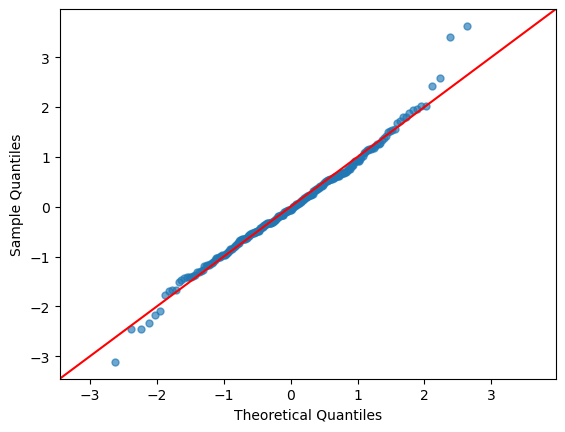

In [168]:
## Assessing normality of residuals Shapiro-Wilk test and QQ-plot
# Null hypothesis: residuals follow a normal distribution
residuals_lr = results_lr.resid
print(shapiro(residuals_lr))
ks_test = kstest(residuals_lr, 'norm', args=(np.mean(residuals_lr), np.std(residuals_lr)))
print(f"Kolmogorov-Smirnov test: Statistic={ks_test.statistic}, p-value={ks_test.pvalue}")
fig = sm.qqplot(residuals_lr, fit=True, line="45", alpha=0.65, markersize=5)
plt.show()

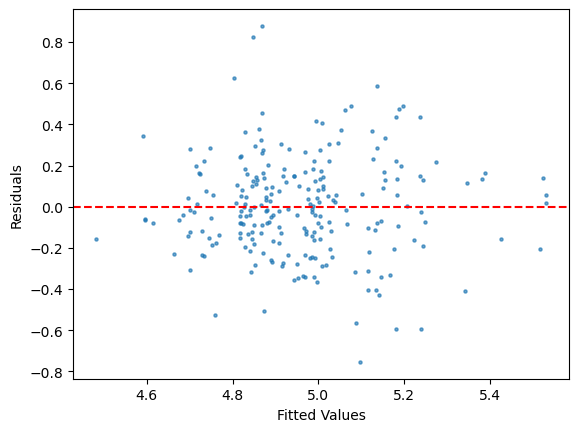

In [169]:
## Assessing linearity: Residual plot
fitted_values_lr = results_lr.fittedvalues
#plt.scatter(fitted_values_lr, np.sqrt(np.abs(residuals_lr/np.std(residuals_lr))), alpha=0.65, s=0.5)
plt.scatter(fitted_values_lr, residuals_lr, alpha=0.65, s=5)
plt.axhline(y=0, color='red', label='y=0', linestyle="--", linewidth=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

C:\Users\mario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mario\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


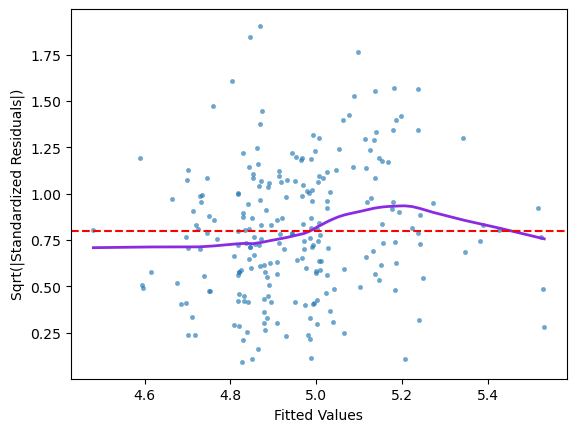

In [170]:
## Assessing homoscedasticity: Residual plot
import seaborn as sns

# Obtain fitted values and residuals from your model
residuals_lr = results_lr.resid

# Standardize residuals
standardized_residuals_lr = residuals_lr / np.std(residuals_lr)

# Compute square root of absolute standardized residuals
sqrt_abs_resid_lr = np.sqrt(np.abs(standardized_residuals_lr))

# Create a DataFrame for plotting
data = pd.DataFrame({
    'Fitted Values': fitted_values_lr,
    'Sqrt Abs Standardized Residuals': sqrt_abs_resid_lr
})

# Create the Scale-Location plot with LOESS line
#plt.figure(figsize=(10, 6))
sns.scatterplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, alpha=0.65, s=10, edgecolor='#1f77b4')
sns.regplot(x='Fitted Values', y='Sqrt Abs Standardized Residuals', data=data, scatter=False, 
            lowess=True, color="blueviolet", line_kws=dict(linestyle="-", linewidth=2))
plt.axhline(y=np.sqrt(2/np.pi), color='red', linestyle='--', lw=1.5)
plt.xlabel("Fitted Values")
plt.ylabel("Sqrt(|Standardized Residuals|)")
#plt.title("Scale-Location Plot with LOESS Smoothing")
#plt.legend()
plt.show()

In [81]:
### Establishing study case

# Scaled variables: ["TWI", "Bayesian_avg_H", "Bayes_mean_A" , 
# "Bayes_mean_R", "Review_count_H", "Score_H", "location_score"]

# Fitted variables: n_rooms_quant_0 + Hotel_class_3 + Hotel_class_45 + 
# Walkability_num_2 + Walkability_num_4 + Walkability_num_5 + 
# Bayesian_avg_H + Review_count_H'

# Study case to be defined (categorical): n_rooms_quant_0, Hotel_class_3, Hotel_class_45, Walkability_num_2
# Walkability_num_4, Walkability_num_5
# Study case to be defined (numerical): Bayesian_avg_H (var1), Review_count_H (var4)

## Get the scale and center values for variables
# IQR:
scale_value1 = scaler.scale_[1]
scale_value4 = scaler.scale_[4]

# Median:
center_value1 = scaler.center_[1]
center_value4 = scaler.center_[4]

# Defining values for numerical variables (use following chunk as reference for these values)
var1 = 4.42
var4 = 217

# Transform
transformed_value1 = (var1 - center_value1) / scale_value1
transformed_value4 = (var4 - center_value4) / scale_value4

print("transformed_value1:", transformed_value1, "transformed_value4:", transformed_value4)

transformed_value1: -0.00478041821849163 transformed_value4: 0.0


In [172]:
df_dummies.median()

Metro_Tram_stop                       1.000000
Closeness_Centrality_Attractions      0.000397
Closeness_Centrality_Restaurants      0.000417
Review_count_H                        0.000000
Score_H                               0.000000
Bayesian_avg_H                        0.000000
avg_price                           137.000000
avg_price_log                         4.919981
price_5_6_august                    126.500000
price_range_min                     114.000000
price_range_max                     160.000000
location_score                        0.000000
Bayes_mean_A                          0.000000
Bayes_mean_R                          0.000000
TWI                                   0.000000
Hotel_class_3                         1.000000
n_rooms_quant_0                       0.000000
n_rooms_quant_1                       0.000000
n_rooms_quant_2                       0.000000
n_rooms_quant_3                       0.000000
Walkability_num_1                     0.000000
Walkability_n

In [89]:
## Defining study case
study_case = [0, 0, 0, 0, 0, 0, transformed_value1, transformed_value4]
#point_estimate = np.exp(np.sum([a*b for a,b in zip(results_lr.params[1:],study_case)]) + results_lr.params[0])

In [90]:
new_data = pd.DataFrame({'const':[1],
                         "n_rooms_quant_0":study_case[0],
                         "Hotel_class_3":study_case[1],
                         "Hotel_class_45":study_case[2],
                         "Walkability_num_2":study_case[3],
                         "Walkability_num_4":study_case[4],
                         "Walkability_num_5":study_case[5],
                         "Bayesian_avg_H":study_case[6],
                         "Review_count_H":study_case[7],

})
predictions = results_lr.get_prediction(new_data)
df_predictions = predictions.summary_frame()
np.exp(df_predictions)

mean   mean_se  mean_ci_lower  mean_ci_upper  obs_ci_lower  \
0  133.629258  1.050289     121.313772     147.194983      81.36933   

   obs_ci_upper  
0     219.45343

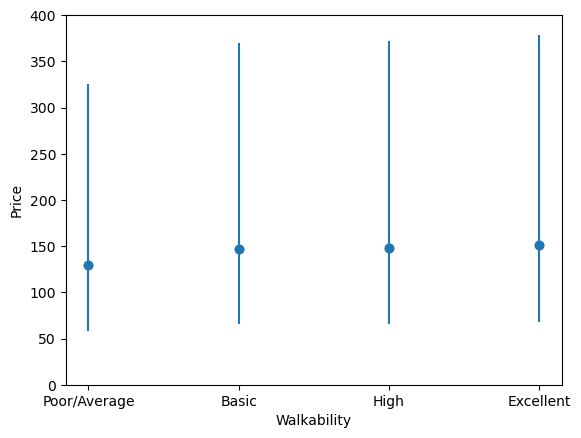

In [178]:
x_walk_score = ["Poor/Average", "Basic", "High", "Excellent"]
point_estimate_y0 = [114.976023, 130.252286, 131.190116, 133.629258]
point_estimate_y = [129.766349, 147.007725, 148.066197, 150.819106]
point_estimate_y2 = [152.944302, 173.265212, 174.51274, 177.757354]
y_error_min = [71.938958, 80.981447, 82.038439, 83.448738]
y_error_max = [195.829597, 223.26111, 223.569602, 228.040114]
plt.scatter(x_walk_score, point_estimate_y)
plt.errorbar(x_walk_score, point_estimate_y, 
            yerr = [y_error_min, y_error_max], fmt = 'o')
plt.xlabel("Walkability")
plt.ylabel("Price")
plt.axis(ymin = 0, ymax = 400)
plt.show()

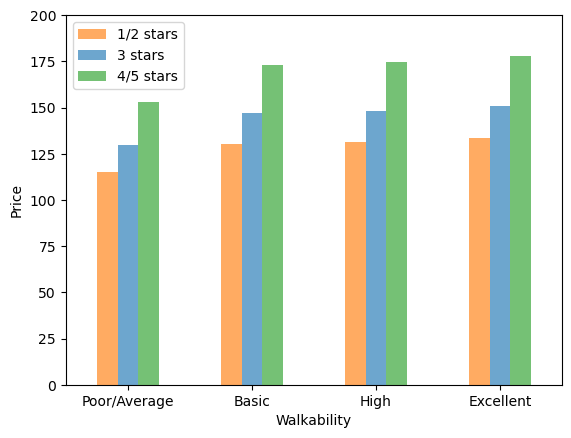

In [179]:

# Create DataFrame
df_point_estimate = pd.DataFrame({
    "Walkability": x_walk_score,
    "point_estimate_y45": point_estimate_y2,
    "point_estimate_y3": point_estimate_y, 
    "point_estimate_y12": point_estimate_y0
})

# Plot the DataFrame
ax = df_point_estimate.plot.bar(x="Walkability", y=["point_estimate_y12", "point_estimate_y3", "point_estimate_y45"], 
                 color=["#ff7f0e", "#1f77b4", "#2ca02c"], alpha=0.65, 
                 xlabel="Walkability", ylabel="Price", rot=0)
ax.set_ylim([0, 200])

# Add labels and title
plt.xlabel("Walkability")
plt.ylabel("Price")
#plt.title("Comparison of Counts by Walkability Levels")
plt.legend(["1/2 stars", "3 stars", "4/5 stars"])

# Show plot
plt.show()

In [100]:
# import the regressor 
from sklearn.tree import DecisionTreeRegressor, export_graphviz  
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [103]:
df.columns

Index(['Hotel name', 'Longitude', 'Latitude', 'Count_A', 'Count_R',
       'Metro_Tram_stop', 'Closeness_Centrality_Attractions',
       'Closeness_Centrality_Restaurants', 'Hotel_class', 'Review_count_H',
       'Score_H', 'Bayesian_avg_H', 'avg_price', 'avg_price_log',
       'price_5_6_august', 'price_range_min', 'price_range_max',
       'location_score', 'n_rooms', 'Count_A_Z', 'Count_R_Z', 'Bayes_mean_A',
       'Bayes_mean_R', 'TWI', 'Walkability', 'Walkability_num',
       'n_rooms_quant'],
      dtype='object')

In [132]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Create a regressor object 
## Using GridSearchCV over min_samples_leaf
regressor = DecisionTreeRegressor(random_state = 42)

# Define X and y data 
df_dummies_dropna = df.dropna(subset="avg_price_log")
var_considered = ["n_rooms_quant", "Hotel_class", 
                  "Walkability_num", "Bayesian_avg_H", 
                  "Bayes_mean_A", "Review_count_H"]
X=df_dummies_dropna[var_considered]

# "Closeness_Centrality_Restaurants", "Closeness_Centrality_Restaurants",
y=df_dummies_dropna.avg_price_log

# Split the data into training and testing sets (80-20 split)
#X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for min_samples_leaf
#param_grid = {"min_samples_leaf":[2]} # 
param_grid = {
    'max_depth': np.arange(3, 5), # np.arange(5, 16)
    #'min_samples_split': np.arange(10, 100),
    'min_samples_leaf': np.arange(5, 16) # np.arange(5, 15)
}

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring="r2")

# Fit the grid search to the data
grid_search.fit(X, y)

# Get the best parameter value
best_max_depth = grid_search.best_params_["max_depth"]
#best_min_samples_split = grid_search.best_params_["min_samples_split"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]
print(f"Best max_depth: {best_max_depth}")
#print(f"Best min_samples_split: {best_min_samples_split}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best min_samples_leaf
final_model = DecisionTreeRegressor(max_depth = best_max_depth, 
                                    min_samples_leaf=best_min_samples_leaf)
final_model.fit(X, y)

# Predict the entire dataset
y_pred = final_model.predict(X)

# Calculate evalation metrics
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

#mse_scores = -cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")
#r2_scores = cross_val_score(final_model, X, y, cv=5, scoring="r2")

# Calculate mean and std of MSE
#mean_mse_scores = np.mean(mse_scores)
#std_mse_scores = np.std(mse_scores)
#mean_r2_scores = np.mean(r2_scores)
#std_r2_scores = np.std(r2_scores)

#print(f"Mean MSE: {mean_mse_scores}")
#print(f"Std MSE: {std_mse_scores}")
#print(f"Mean R^2: {mean_r2_scores}")
#print(f"Std R^2: {std_r2_scores}")

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {1-(1-r2)*(len(X)-1)/(len(X)-len(var_considered)-1)}")

Best max_depth: 4
Best min_samples_leaf: 9
MSE: 0.05666265173934787
R^2: 0.3746344991489319
Adj R^2: 0.35803187523253177


In [133]:
print("mean_test_score:" , grid_search.cv_results_["mean_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("std_test_score:" , grid_search.cv_results_["std_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])
print("rank_test_score:" , grid_search.cv_results_["rank_test_score"][np.argmin(grid_search.cv_results_["rank_test_score"])])

mean_test_score: 0.12206292186053853
std_test_score: 0.2755620607738749
rank_test_score: 1


In [117]:
grid_search.cv_results_

{'mean_fit_time': array([0.00448329, 0.00409882, 0.00429971, 0.00452657, 0.00420725,
        0.00374241, 0.00465887, 0.00479965, 0.00451305, 0.00501015]),
 'std_fit_time': array([1.33034035e-03, 3.00588403e-04, 4.59384248e-04, 4.78446483e-04,
        3.96416317e-04, 5.18107839e-04, 4.98301904e-04, 1.06387270e-03,
        8.14775885e-04, 4.70779143e-05]),
 'mean_score_time': array([0.00480134, 0.00290082, 0.0026526 , 0.00259914, 0.00260084,
        0.00265539, 0.00286496, 0.00277786, 0.00241053, 0.00229375]),
 'std_score_time': array([0.00685921, 0.00030053, 0.00044966, 0.00066421, 0.00049437,
        0.00066254, 0.00084692, 0.00105982, 0.00054061, 0.00044034]),
 'param_max_depth': masked_array(data=[2, 2, 2, 2, 2, 3, 3, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[5, 6, 7, 8, 9, 5, 6, 7, 8, 9],
              mask=[

In [79]:
# Predict on the testing data (if train_test_split in the previous chunk is uncommented)
#y_pred = final_model.predict(X_test)

# Calculate evaluation metrics on the testing data
#mse = mean_squared_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)
#adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(var_considered) - 1)

#print(f"MSE: {mse}")
#print(f"R^2: {r2}")
#print(f"Adjusted R^2: {adj_r2}")

In [85]:
# Feature importance
j = 0
var_considered_filtered = []
for feature in var_considered:
    print(feature, final_model.feature_importances_[j])
    
    if final_model.feature_importances_[j] > 0:
        var_considered_filtered.append(feature)
        
    j += 1

n_rooms_quant_0 0.13052261548795077
n_rooms_quant_1 0.0
n_rooms_quant_2 0.0
Hotel_class_3 0.0
Hotel_class_45 0.01814623930373159
Bayesian_avg_H 0.13200226621837344
Bayes_mean_A 0.04007966352989565
Bayes_mean_R 0.07543605415573681
TWI 0.17502643474657126
Review_count_H 0.42878672655774047


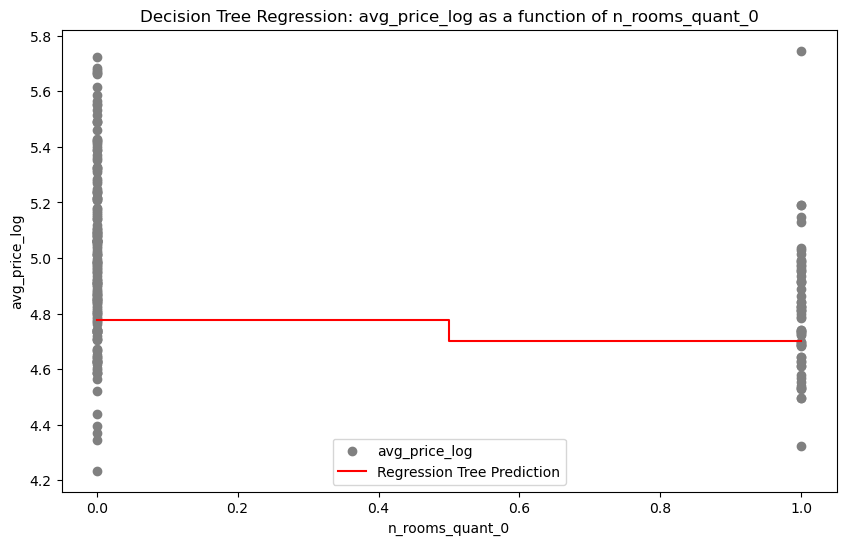

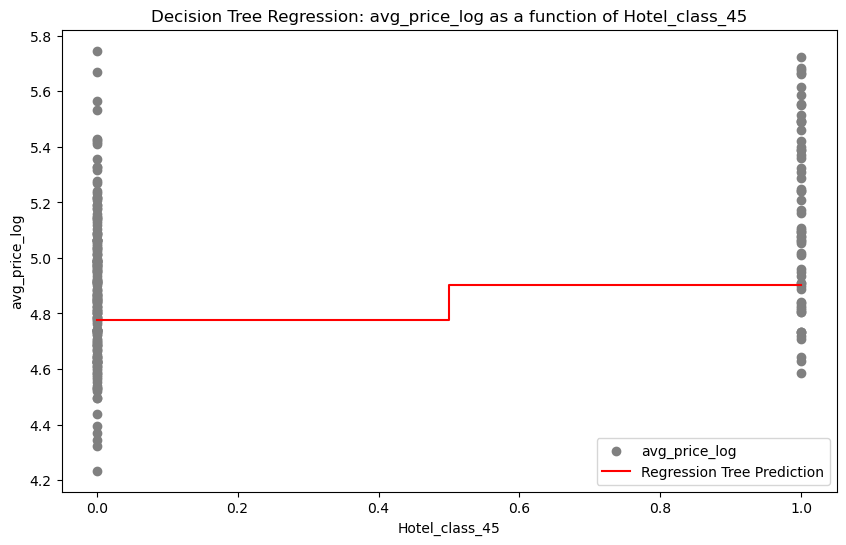

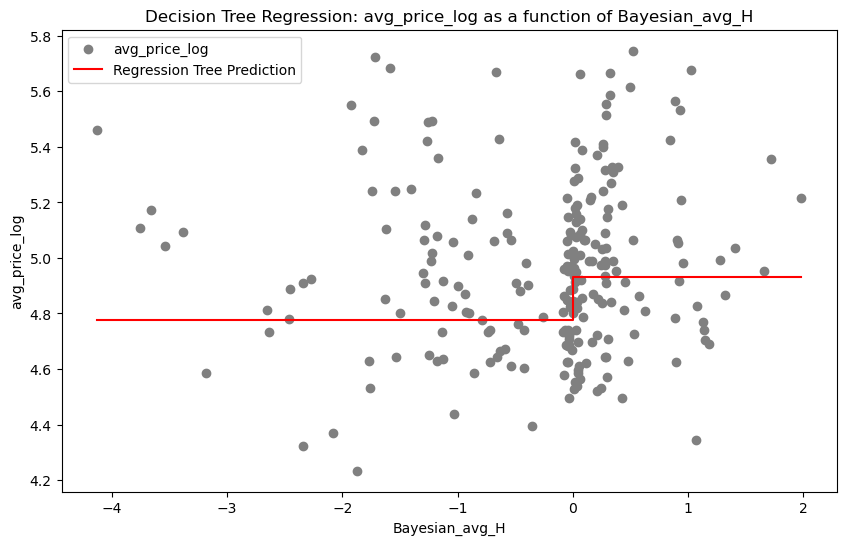

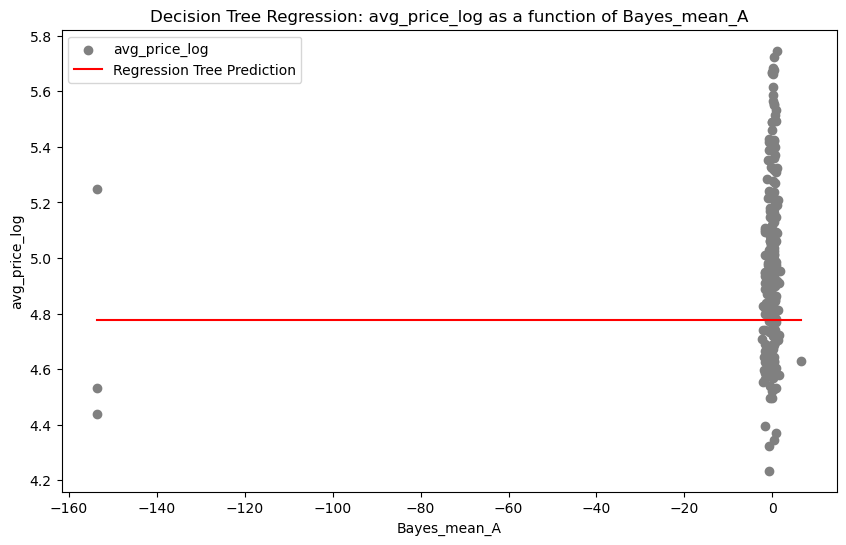

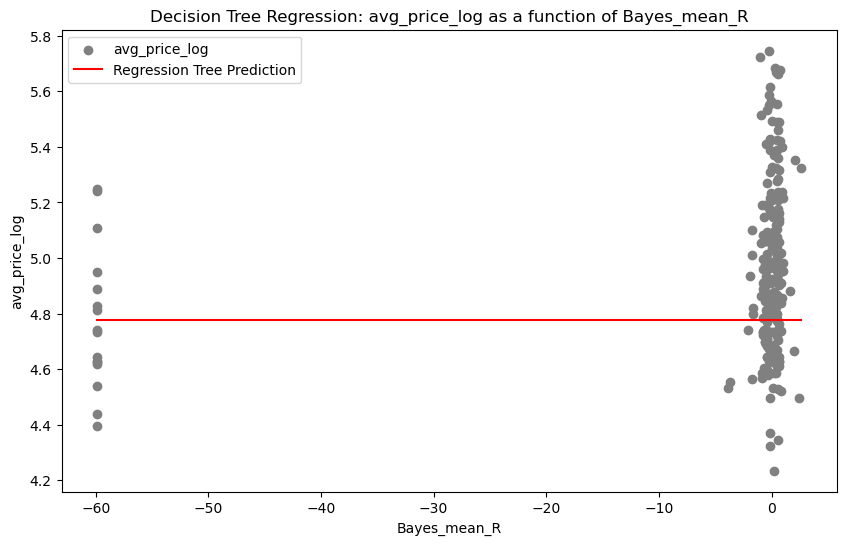

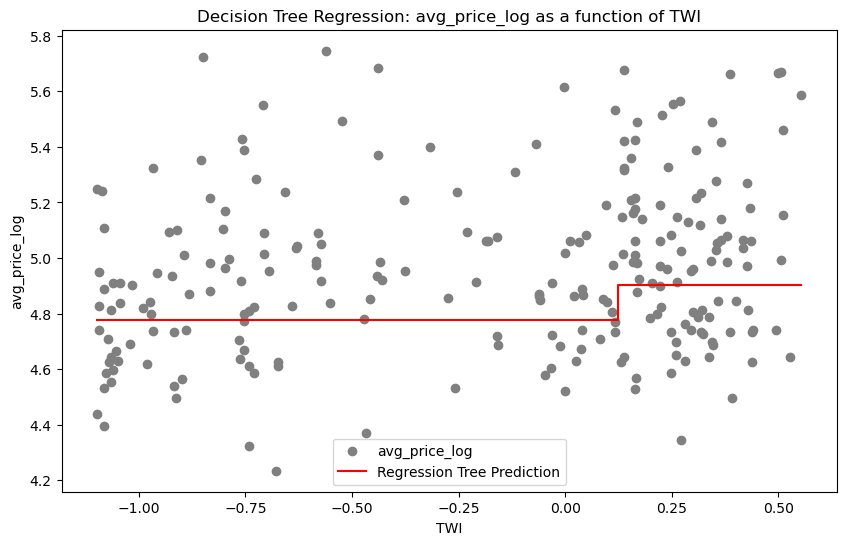

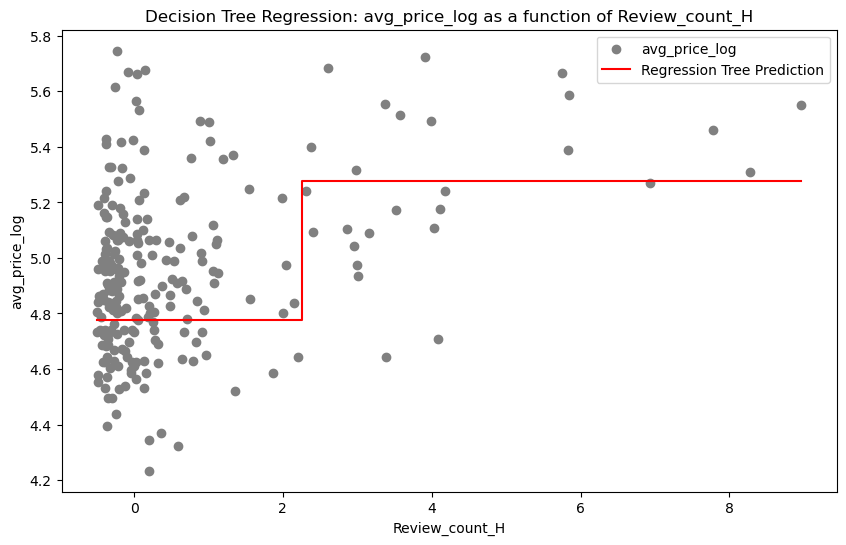

In [86]:
# Function to plot the decision tree predictions for a given feature
def plot_feature_decision_boundary(feature_name, output_label):
    plt.figure(figsize=(10, 6))

    # Scatter plot of the feature vs avg_price
    plt.scatter(X[feature_name], y, color='gray', label=output_label)

    # Create a grid of feature values
    feature_values = np.linspace(X[feature_name].min(), X[feature_name].max(), 500)

    # Create a grid of input features
    X_grid = pd.DataFrame(np.tile(X.mean().values, (500, 1)), columns=X.columns)
    X_grid[feature_name] = feature_values

    # Predict avg_price for the grid values
    y_grid_pred = final_model.predict(X_grid)

    # Plot the decision boundary
    plt.step(feature_values, y_grid_pred, color='red', label='Regression Tree Prediction', where='mid')

    plt.xlabel(feature_name)
    plt.ylabel(output_label)
    plt.title(f"Decision Tree Regression: {output_label} as a function of {feature_name}")
    plt.legend()
    plt.show()

# Plot decision boundaries for each feature
for feature in var_considered_filtered:
    plot_feature_decision_boundary(feature, "avg_price_log")

In [125]:
# export the decision tree to a tree.dot file 
# for visualizing the plot easily anywhere 
# https://dreampuf.github.io/GraphvizOnline/#digraph%20Tree%20%7B%0D%0Anode%20%5Bshape%3Dbox%2C%20fontname%3D%22helvetica%22%5D%20%3B%0D%0Aedge%20%5Bfontname%3D%22helvetica%22%5D%20%3B%0D%0A0%20%5Blabel%3D%22TWI%20%3C%3D%208.771%5Cnsquared_error%20%3D%20454.476%5Cnsamples%20%3D%2018%5Cnvalue%20%3D%20117.694%22%5D%20%3B%0D%0A1%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%2062.776%5Cnsamples%20%3D%207%5Cnvalue%20%3D%2098.286%22%5D%20%3B%0D%0A0%20-%3E%201%20%5Blabeldistance%3D2.5%2C%20labelangle%3D45%2C%20headlabel%3D%22True%22%5D%20%3B%0D%0A2%20%5Blabel%3D%22TWI%20%3C%3D%200.954%5Cnsquared_error%20%3D%2019.297%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20104.375%22%5D%20%3B%0D%0A1%20-%3E%202%20%3B%0D%0A3%20%5Blabel%3D%22squared_error%20%3D%2033.062%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20102.75%22%5D%20%3B%0D%0A2%20-%3E%203%20%3B%0D%0A4%20%5Blabel%3D%22squared_error%20%3D%200.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20106.0%22%5D%20%3B%0D%0A2%20-%3E%204%20%3B%0D%0A5%20%5Blabel%3D%22squared_error%20%3D%205.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%2090.167%22%5D%20%3B%0D%0A1%20-%3E%205%20%3B%0D%0A6%20%5Blabel%3D%22Hotel_class_23%20%3C%3D%200.5%5Cnsquared_error%20%3D%20311.475%5Cnsamples%20%3D%2011%5Cnvalue%20%3D%20130.045%22%5D%20%3B%0D%0A0%20-%3E%206%20%5Blabeldistance%3D2.5%2C%20labelangle%3D-45%2C%20headlabel%3D%22False%22%5D%20%3B%0D%0A7%20%5Blabel%3D%22squared_error%20%3D%20269.389%5Cnsamples%20%3D%203%5Cnvalue%20%3D%20150.333%22%5D%20%3B%0D%0A6%20-%3E%207%20%3B%0D%0A8%20%5Blabel%3D%22TWI%20%3C%3D%2059.023%5Cnsquared_error%20%3D%20115.027%5Cnsamples%20%3D%208%5Cnvalue%20%3D%20122.438%22%5D%20%3B%0D%0A6%20-%3E%208%20%3B%0D%0A9%20%5Blabel%3D%22TWI%20%3C%3D%2039.613%5Cnsquared_error%20%3D%204.922%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20129.625%22%5D%20%3B%0D%0A8%20-%3E%209%20%3B%0D%0A10%20%5Blabel%3D%22squared_error%20%3D%200.562%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20129.25%22%5D%20%3B%0D%0A9%20-%3E%2010%20%3B%0D%0A11%20%5Blabel%3D%22squared_error%20%3D%209.0%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20130.0%22%5D%20%3B%0D%0A9%20-%3E%2011%20%3B%0D%0A12%20%5Blabel%3D%22TWI%20%3C%3D%2071.824%5Cnsquared_error%20%3D%20121.812%5Cnsamples%20%3D%204%5Cnvalue%20%3D%20115.25%22%5D%20%3B%0D%0A8%20-%3E%2012%20%3B%0D%0A13%20%5Blabel%3D%22squared_error%20%3D%20240.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20114.5%22%5D%20%3B%0D%0A12%20-%3E%2013%20%3B%0D%0A14%20%5Blabel%3D%22squared_error%20%3D%202.25%5Cnsamples%20%3D%202%5Cnvalue%20%3D%20116.0%22%5D%20%3B%0D%0A12%20-%3E%2014%20%3B%0D%0A%7D
export_graphviz(final_model, out_file ='tree_Napoli_avg_price_log.dot', 
               feature_names = var_considered)  

#### GAM

In [87]:
GAM_fit = True
if GAM_fit:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

GAM R²: 0.41522115497397705


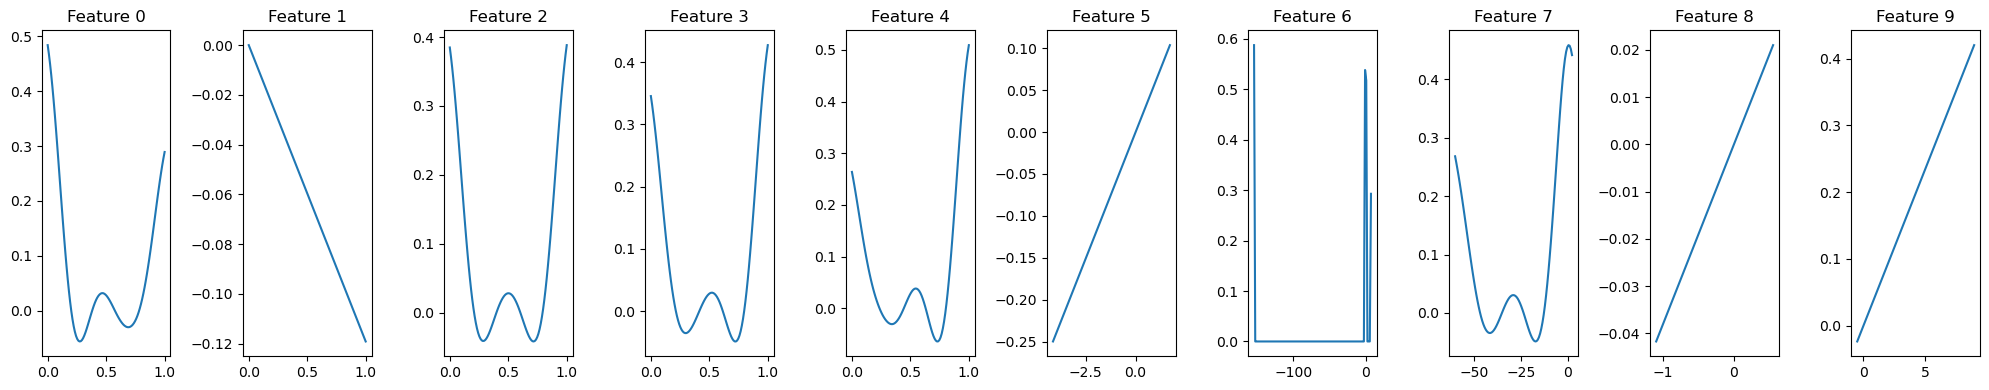

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.1372
Link Function:                     IdentityLink Log Likelihood:                                 -1081.2677
Number of Samples:                          186 AIC:                                             2194.8098
                                                AICc:                                            2198.0852
                                                GCV:                                                0.0697
                                                Scale:                                              0.0595
                                                Pseudo R-Squared:                                   0.3992
Feature Function                  Lam

C:\Users\mario\AppData\Local\Temp\ipykernel_2064\1264965358.py:31: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [117]:
# Install pyGAM
# !pip install pygam
if GAM_fit:
    from pygam import LinearGAM, s, f, l

    # Fit GAM model
    #gam = LinearGAM(s(0)  + s(1) + s(2) + s(3, basis='ps') + s(4, basis='ps') + s(5) + s(6, basis='ps')).fit(X, y)

    X=X[["n_rooms_quant_0", "n_rooms_quant_1", "n_rooms_quant_2", 
           "Hotel_class_3", "Hotel_class_45", 
           "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", 
           "TWI", "Review_count_H"]] #, 
    X_test=X_test[["n_rooms_quant_0", "n_rooms_quant_1", "n_rooms_quant_2", 
           "Hotel_class_3", "Hotel_class_45", 
           "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", 
           "TWI", "Review_count_H"]] #, "Bayesian_avg_mean_A_Z"
    gam = LinearGAM(s(0) + l(1) + s(2) + s(3) + s(4) + l(5) + f(6) + s(7) + l(8) + l(9)).fit(X, y)

    y_pred_gam = gam.predict(X_test)
    r2_gam = r2_score(y_test, y_pred_gam)
    print(f"GAM R²: {r2_gam}")

    # Plot the partial dependence
    fig, axs = plt.subplots(1, X.shape[1], figsize=(20, 4))
    for i, ax in enumerate(axs):
        XX = gam.generate_X_grid(term=i)
        ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
        ax.set_title(f'Feature {i}')
    plt.tight_layout()
    plt.show()
    print(gam.summary())

#### Gradient Boosting

In [120]:
import warnings
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

warnings.filterwarnings("ignore", category=DeprecationWarning)

# Define X and y data 
df_dummies_dropna = df_dummies.dropna(subset=["avg_price_log"])

var_considered = ["n_rooms_quant_0", "n_rooms_quant_1", "n_rooms_quant_2", 
           "Hotel_class_3", "Hotel_class_45", 
           "Bayesian_avg_H", "Bayes_mean_A", "Bayes_mean_R", 
           "TWI", "Review_count_H"]

X = df_dummies_dropna[var_considered]
y = df_dummies_dropna["avg_price_log"]

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the grid for Gradient Boosting parameters
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': np.arange(3, 15),
    'min_samples_leaf': np.arange(3, 15)
}

# Create a Gradient Boosting regressor object
gb_regressor = GradientBoostingRegressor(random_state=42)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=gb_regressor, param_grid=param_grid, cv=5, scoring="neg_mean_squared_error")

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameter values
best_n_estimators = grid_search.best_params_["n_estimators"]
best_learning_rate = grid_search.best_params_["learning_rate"]
best_max_depth = grid_search.best_params_["max_depth"]
best_min_samples_leaf = grid_search.best_params_["min_samples_leaf"]

print(f"Best n_estimators: {best_n_estimators}")
print(f"Best learning_rate: {best_learning_rate}")
print(f"Best max_depth: {best_max_depth}")
print(f"Best min_samples_leaf: {best_min_samples_leaf}")

# Fit the final model with the best parameters
final_model = GradientBoostingRegressor(
    n_estimators=best_n_estimators, 
    learning_rate=best_learning_rate,
    max_depth=best_max_depth,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
final_model.fit(X_train, y_train)

# Predict the test set
y_pred = final_model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - len(var_considered) - 1)

print(f"MSE: {mse}")
print(f"R^2: {r2}")
print(f"Adj R^2: {adj_r2}")

Best n_estimators: 500
Best learning_rate: 0.01
Best max_depth: 3
Best min_samples_leaf: 12
MSE: 0.061941748782564345
R^2: 0.2962883983092902
Adj R^2: 0.26458967751241136


#### Isochrone maps

C:\Users\mario\AppData\Local\Temp\ipykernel_20148\3068561464.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_var)


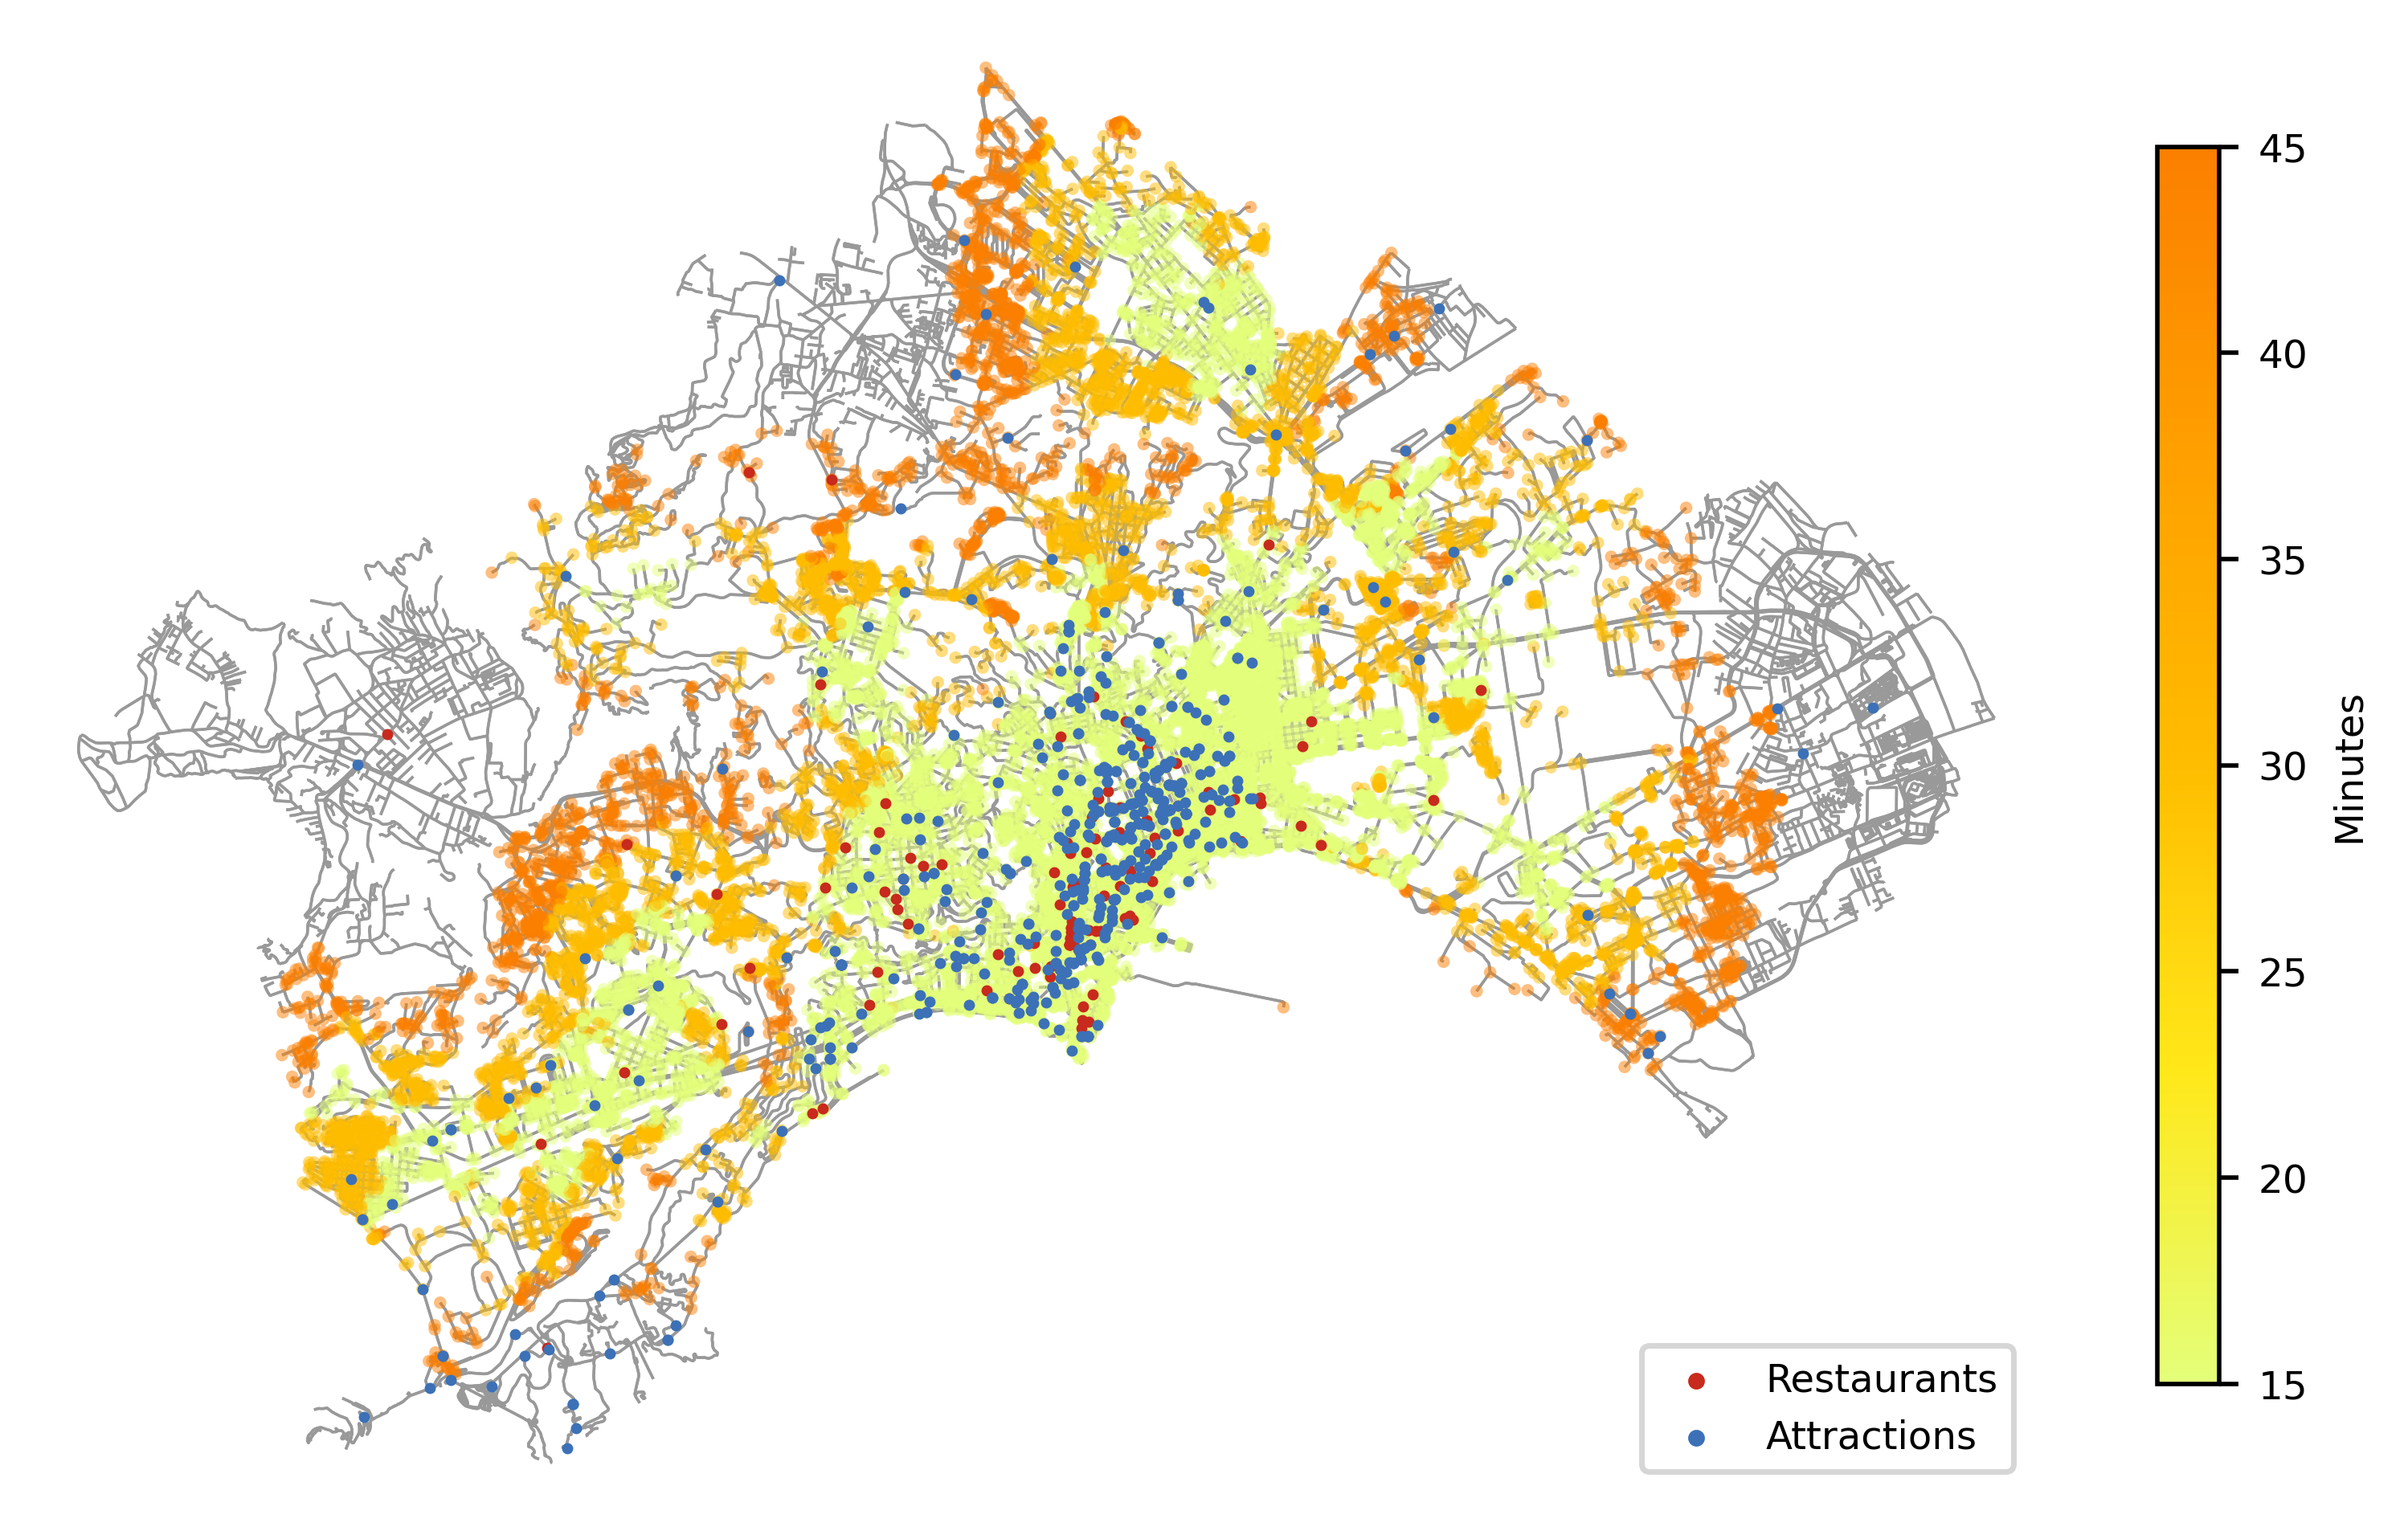

In [99]:
G2 = G
trip_times = [X_minutes, 30, 45]  # in minutes

cmap_var = "Wistia"#"Greens" #"Wistia"  #"summer" #
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in G2.edges(data=True, keys=True):
    data["time"] = data["length"] / speed_mm
    
# get one color for each isochrone (r, g, b, alpha)
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap=cmap_var, start=1, stop=0, alpha = 1)
# color the nodes according to isochrone then plot the street network
node_colors = {}
node_time = {}

for center_node in hotels_df["id_nearest_node_H"]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G2, center_node, radius=trip_time, distance="time")
        for node in subgraph.nodes():
            if node in node_time and trip_time < node_time[node]:
                node_colors[node] = color
                node_time[node] = trip_time
            elif node not in node_time:
                node_colors[node] = color
                node_time[node] = trip_time
nc = [node_colors[node] if node in node_colors else "none" for node in G2.nodes()]
ns = [5 if node in node_colors else 0 for node in G2.nodes()]
mpl.rcParams['figure.dpi'] = 500

cmap = plt.cm.get_cmap(cmap_var)
norm = plt.Normalize(vmin=np.min(trip_times), vmax=np.max(trip_times))
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])


fig, ax = ox.plot_graph(G2, node_color=nc, node_size=ns, node_alpha=0.5,
                        edge_linewidth=0.5, edge_color="#999999", bgcolor="white", 
                        show=False, close=False)

    
# Adding Hotels, Restaurants, Attractions, and Tram/Metro stations
#ax.scatter(hotels_df["x_nearest_node_H"].values, hotels_df["y_nearest_node_H"].values, 
#           color='green', s=10, zorder=2, marker = 'o', label="Hotels")
ax.scatter(top_k_R_df["x_nearest_node_R"].values, top_k_R_df["y_nearest_node_R"].values, 
           color='#c82a1d', s=1, zorder=2, marker = 'o', label="Restaurants")
ax.scatter(top_k_A_df["x_nearest_node_A"].values, top_k_A_df["y_nearest_node_A"].values, 
           color='#3c71b7', s=1, zorder=2, marker = 'o', label="Attractions")
ax.legend(loc='lower right', fontsize = "x-small", markerscale = 2)

cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', shrink = 0.5)
cb.ax.tick_params(labelsize=7)
cb.set_label('Minutes', fontsize = 7)

plt.show()

#### For plotting some auxiliary images

In [ ]:
import osmnx as ox
import matplotlib as mpl


location_point = (45.3986490196774, 11.874350466689211)

place_name = "Padova, Italy"

mpl.rcParams['figure.dpi'] = 500
# create network from point, inside bounding box of N, S, E, W each 750m from point
#plt.title("Padova: All street network'")
#G_walk = ox.graph_from_point(location_point, dist=dist, dist_type="bbox", network_type="walk", simplify = False)

#Drive network
G_walk = ox.graph_from_point(location_point, dist=300, dist_type="bbox", network_type="walk", simplify = False)
#G_drive = ox.graph_from_place(place_name, network_type="walk", retain_all=True, simplify = False)

fig, ax = ox.plot_graph(G_walk, node_color="white", edge_color="gray", node_edgecolor = "blue",
                        edge_linewidth=1, node_size=1.5, bgcolor="white", 
                        figsize=(6, 6)) 

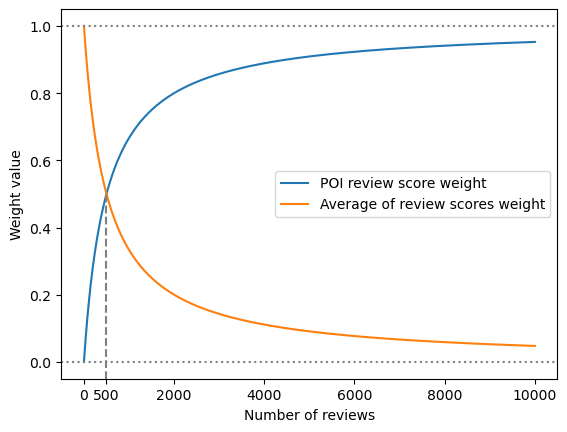

In [167]:
plt.style.use('default')
xx = np.linspace(0, 10000, 10000)
zz_avg = 500
yy = xx/(xx + zz_avg)
fig,ax=plt.subplots(1,1)
ax.plot(xx, yy)
ax.plot(xx, (1-yy))
ax.set_ylabel("Weight value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI review score weight", "Average of review scores weight"])
ax.axvline(x=zz_avg, ymax=0.5, linestyle = "--", color="gray")
ax.axhline(y=1, linestyle = "dotted", color="gray")
ax.axhline(y=0, linestyle = "dotted", color="gray")
ax.set_xticks([0, 500, 2000, 4000, 6000, 8000, 10000])

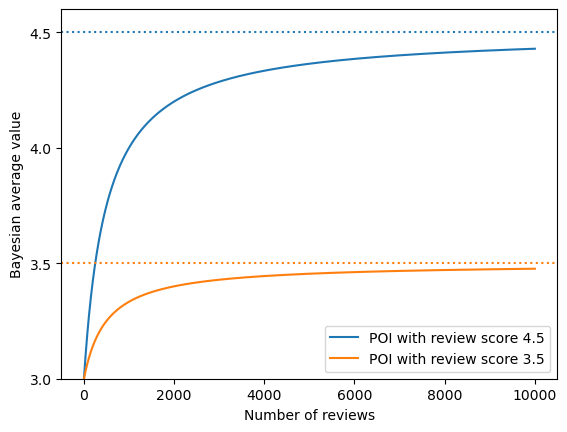

In [168]:
fig, ax = plt.subplots(1,1)
ax.plot(xx, yy*4.5 + (1-yy)*3)
ax.plot(xx, yy*3.5 + (1-yy)*3)
ax.axhline(y=4.5, linestyle = "dotted", color="#1f77b4") 
ax.axhline(y=3.5, linestyle = "dotted", color="#ff7f0e")
ax.set_yticks(np.arange(3, 5, 0.5))
ax.set_ylim([3, 4.6])
ax.set_xticks([0, 2000, 4000, 6000, 8000, 10000])
ax.set_ylabel("Bayesian average value")
ax.set_xlabel("Number of reviews")
ax.legend(["POI with review score 4.5", "POI with review score 3.5"])

In [104]:
df.Walkability.value_counts()

Walkability
Excelent    68
High        66
Poor        63
Basic       32
Average     14
Name: count, dtype: int64

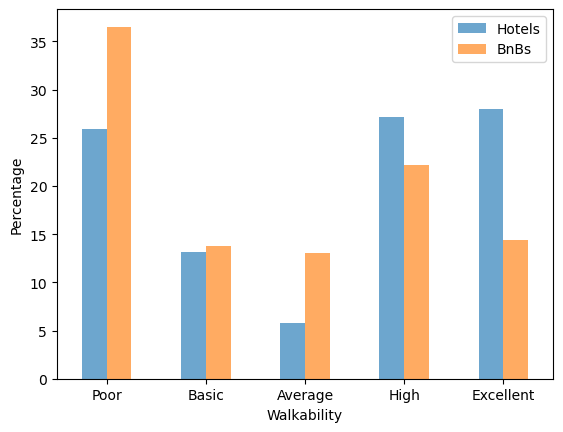

In [87]:
# Sample data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

walkability_levels = ['Poor', 'Basic', 'Average', 'High', 'Excellent']
counts_for_plot_hotels_1 = [63, 32, 14, 66, 68]
counts_for_plot_airbnb_1 = [2564, 965, 918, 1559, 1014]

counts_for_plot_hotels = [x * 100 / np.sum(counts_for_plot_hotels_1) for x in counts_for_plot_hotels_1]
counts_for_plot_airbnb = [x * 100 / np.sum(counts_for_plot_airbnb_1) for x in counts_for_plot_airbnb_1]

# Create DataFrame
df = pd.DataFrame({
    "Walkability": walkability_levels,
    "Counts_hotels": counts_for_plot_hotels,
    "Counts_airbnb": counts_for_plot_airbnb
})

# Plot the DataFrame
ax = df.plot.bar(x="Walkability", y=["Counts_hotels", "Counts_airbnb"], 
                 color=["#1f77b4", "#ff7f0e"], alpha=0.65, 
                 xlabel="Walkability", ylabel="Count", rot=0)

# Add labels and title
plt.xlabel("Walkability")
plt.ylabel("Percentage")
#plt.title("Comparison of Counts by Walkability Levels")
plt.legend(["Hotels", "BnBs"])

# Show plot
plt.show()